# Intro
- Code to estimate Gaussians of images 400 to 599 in the database

In [8]:
!pip install -q ultralytics==8.0.154

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.0/613.0 kB 8.6 MB/s eta 0:00:00


In [9]:
!pip install -q adjustText==0.8

In [10]:
!pip install -q plotly==5.15.0

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [12]:
import inspect

In [13]:
import os
import random
import shutil
import pandas as pd
import numpy as np

from datetime import datetime

In [14]:
from scipy.ndimage import laplace
from scipy.ndimage import gaussian_filter
from scipy.signal import savgol_filter
from scipy.signal import argrelextrema
import scipy.stats as stats
import scipy.io
from scipy.optimize import linear_sum_assignment

from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from skimage.feature import peak_local_max
import skimage.color
import skimage.filters

In [15]:
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable

from adjustText import adjust_text
import plotly.graph_objects as go

In [16]:
from ultralytics import YOLO

In [17]:
import cv2
from PIL import Image
from google.colab.patches import cv2_imshow

In [18]:
from ultralytics.utils import plotting

In [19]:
os.listdir("/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/")

['Data',
 'image_preprocessors.ipynb',
 'image_extractors.ipynb',
 'Models',
 'transforms.ipynb',
 'Results',
 'experimentation.ipynb',
 'yolo_labelling.ipynb',
 'archived_code.ipynb',
 'pipelines.ipynb',
 'error_estimation.ipynb',
 'auxiliary_functions.ipynb',
 'gaussian_generator.ipynb',
 'Draws',
 'gaussian_estimation.ipynb',
 'data_analysis.ipynb',
 'aux_plotter.ipynb',
 'predict_T80Kenji.ipynb',
 'run_estimation_1.ipynb',
 'run_estimation_12.ipynb',
 'run_estimation_2.ipynb',
 'run_estimation_3.ipynb',
 'run_estimation_4.ipynb']

# Load modules

In [20]:
# Load some modulus
# Auxiliary functions in computation and plotting
%run "/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/auxiliary_functions.ipynb"
%run "/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/aux_plotter.ipynb"

# Pipelines contain steps of the analysis from the "initial" data to the final result
%run "/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/pipelines.ipynb"

# Transforms contain the transformations of the image (example laplacian)
%run "/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/transforms.ipynb"

# Image extractors
%run "/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/image_extractors.ipynb"

# Dist generation
%run "/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/gaussian_generator.ipynb"

# Dist estimation
%run "/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/gaussian_estimation.ipynb"

# Yolo labelling
%run "/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/yolo_labelling.ipynb"

# Error estimation
%run "/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/error_estimation.ipynb"

In [21]:
print(inspect.getsource(ppl_fit_gaussians))

    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"{func.__name__} executed in {end_time - start_time} seconds")
        return result



# Data from CNR

## Load
- Real size of the tile is roughly equal to 2 pixel / mm

In [22]:
# Load 400 gaussians
mat = scipy.io.loadmat('/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/db_80beam.mat')
print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'F_data', 'Fit_flux', 'beta'])


In [23]:
# Generate GRID
width = 0.143
length = 0.377
x, y = generate_grid((0, width), (0, length), 143, 377)

## Box of the gaussians - using dispersion_x and dispersion_y (from true parameters)

In [ ]:
# Load data
n_image = 409
labels_type = "Labelsv0_detect"
task = "detect"

image_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/gaussian_{n_image}.png"
label_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/{labels_type}/gaussian_{n_image}.txt"

# Image - z intensities
image = [x, y, mat['F_data'][:,:, n_image]]

# Parameters extraction
amplitude, xs, ys, dispersion_x, dispersion_y = parameters_extract(mat['Fit_flux'], n_image)

In [ ]:
# Structure covariances
covariances = [np.diag(cov) for cov in zip((dispersion_x/np.sqrt(2))**2, (dispersion_y/np.sqrt(2))**2)]

Number of indentifiable Gaussians (center in the image): 79


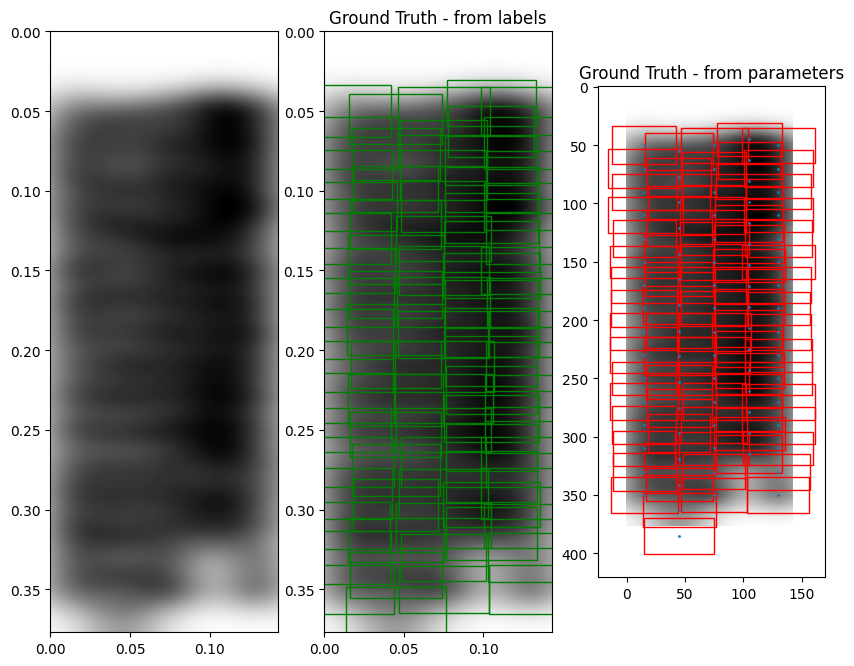

In [ ]:
# Open the image file
im = Image.open(image_path)

# Create figure and axes
fig, axs = plt.subplots(1, 3, figsize = (10, 10))

# Display the image
axs[2].imshow(im)
plot_boxes_gmm(means = list(zip(xs, ys)),
               covariances = covariances,
               ax = axs[2],
               beta = 3)
axs[2].set_title("Ground Truth - from parameters")
axs[2].scatter(xs * 1000, ys * 1000, s = 1)

# Labelling
x, y, z = gaussians_labelled(image_path,
                   label_path,
                   axs[1],
                   task = task,
                   colorbar = False)
axs[1].set_title("Ground Truth - from labels")

# Image
plot_grayscale(x, y, z, colorbar = False, ax = axs[0])

axs[0].invert_yaxis()
axs[1].invert_yaxis()

for ax in axs:
  ax.xaxis.label.set_text("")
  ax.yaxis.label.set_text("")

# [ESTIMATION PART III]
- Images: 400 - 599
  -  All amplitudes are higher around 2.1E6 (400%)
  - x center coincides with beta xs
  - y center Coincides with beta ys
  - dispersion in x Higher dispersion in x direction around 0.017 (170%)
  - dispersion in y Higher dispersion in y direction around 0.01 (170%)


## [ESTIMATION] Pipeline ppl_SCIKIT_GMM
- Processing using Scikit-image library
- Mean and covariances from GMM

In [24]:
# Load data
n_image = 401

# Image - z intensities
image = [x, y, mat['F_data'][:,:, n_image]]

# Parameters extraction
amplitude, xs, ys, dispersion_x, dispersion_y = parameters_extract(mat['Fit_flux'], n_image)

### Centers estimation

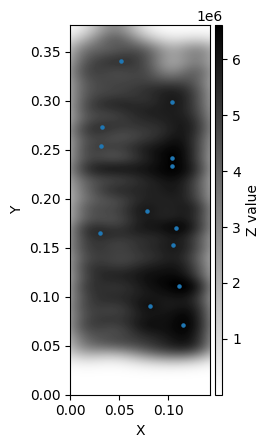

In [25]:
# Find local maxima coordinates
coordinates = peak_local_max(image[2], min_distance = 1)

# 2D plot in grayscale - selected image for initial development
fig, ax = plt.subplots()
plot_grayscale(x, y, image[2], ax)
ax.scatter(image[0][0, [coordinates[:, 1]]], image[1][coordinates[:, 0], 0], s = 5)

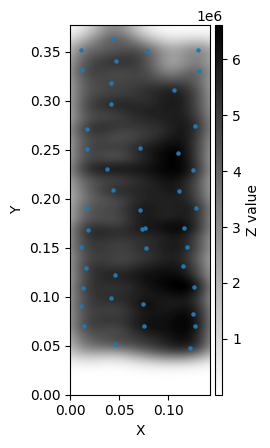

In [26]:
# Find local maxima coordinates
z_laplace = laplace(image[2])
z_laplace[np.nonzero(z_laplace >= 0)] = 0
coordinates = peak_local_max(-1 * z_laplace, min_distance = 1)

# 2D plot in grayscale - selected image for initial development
fig, ax = plt.subplots()
plot_grayscale(x, y, image[2], ax)
ax.scatter(image[0][0, [coordinates[:, 1]]], image[1][coordinates[:, 0], 0], s = 5)

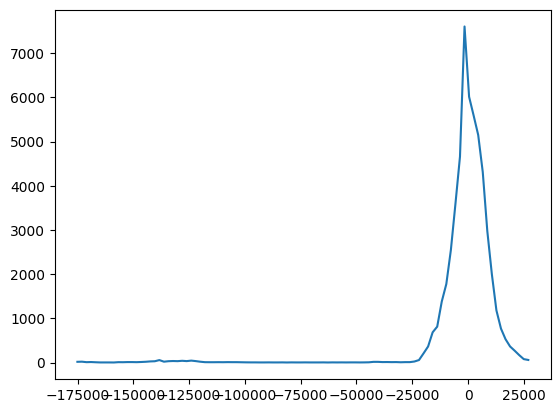

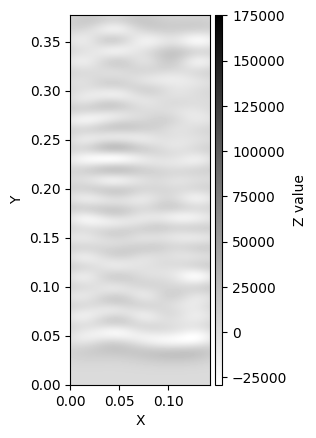

In [27]:
# Thresholding laplacian
# histogram of values
histogram, bin_edges = np.histogram(-1 * laplace(image[2]), bins = 100)

fig, ax = plt.subplots()
ax.plot(bin_edges[0:-1], histogram)

fig, ax = plt.subplots()
plot_grayscale(x, y, laplace(image[2]), ax)

estimate_parameters_gmm executed in 11.190528154373169 seconds
ppl_fit_gaussians executed in 11.880757331848145 seconds


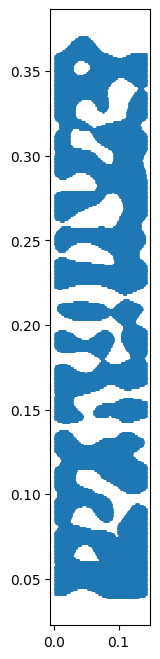

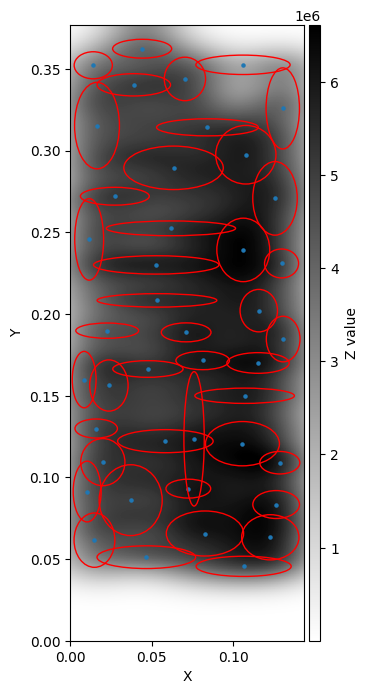

In [28]:
# Estimate Gaussian - Final prediction
(means,
 covariances,
 angles,
 amplitudes) = ppl_fit_gaussians(image,
                                 means_init = 'laplace',
                                 peak_method = 'laplace',
                                 em_iterations = 1000,
                                 covariance_gaussians_type = 'diag',
                                 n_gaussians = None,
                                 image_ranges = [(0, 0.143), (0, 0.377)],
                                 image_size = [143, 377],
                                 fig_size = (10, 8),
                                 plot = True,
                                 plot_points = True)

In [29]:
labels_type = "Labelsv0_detect"
task = "detect"
image_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/gaussian_{n_image}.png"
label_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/{labels_type}/gaussian_{n_image}.txt"

Number of indentifiable Gaussians (center in the image): 79


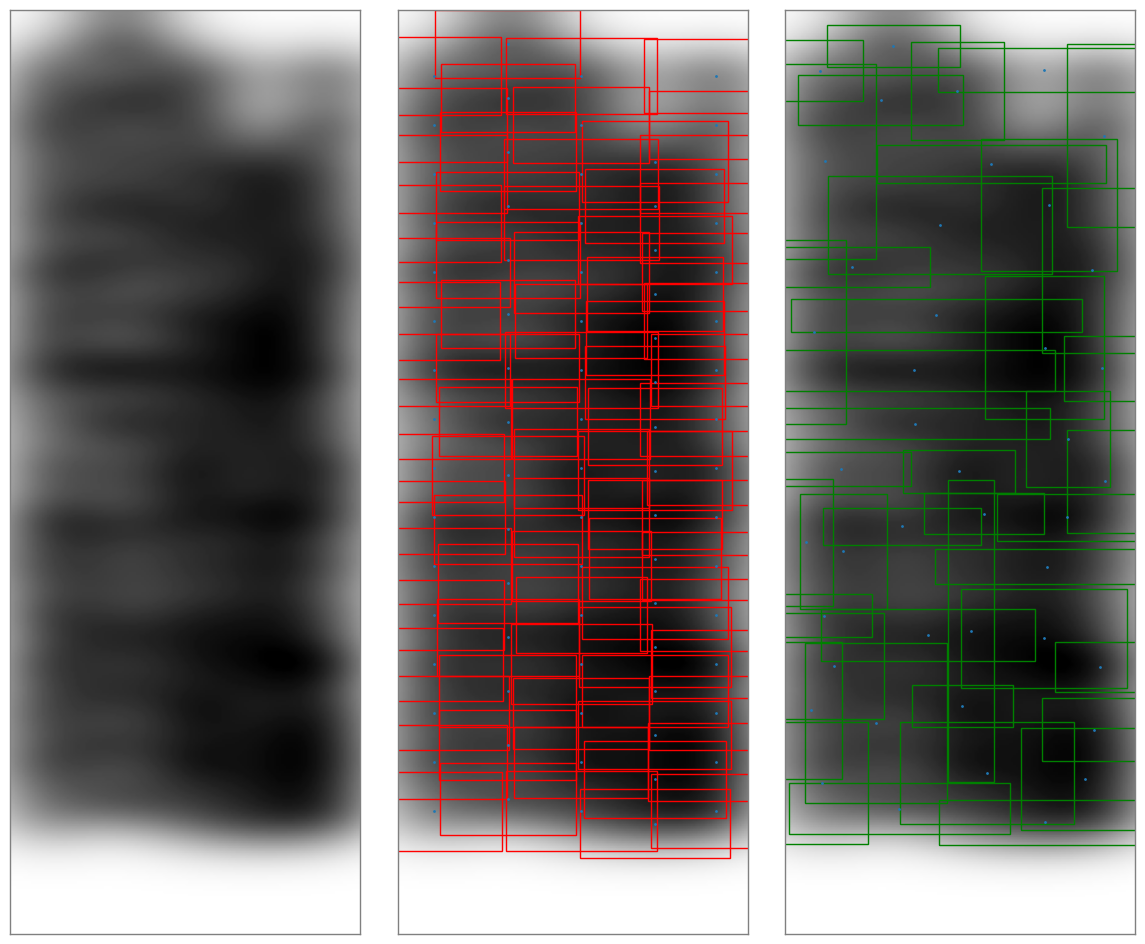

In [30]:
# Open the image file
im = Image.open(image_path)

# Create figure and axes
fig, axs = plt.subplots(1, 3, figsize = (15, 12))

# Display the image and plot predicted centers
axs[2].imshow(im)
plot_boxes_gmm(means = means,
               covariances = covariances,
               ax = axs[2],
               beta = 3,
               edge_color = 'g')
axs[2].set_ylim(ax.get_ylim()[::-1])
axs[2].scatter(means[:,0] * 1000, means[:, 1] * 1000, s = 1)
# axs[2].axis('off')
axs[2].set_xlim(0, 143)
axs[2].set_ylim(0, 377)

#axs[2].set_title("Prediction")

# Labelling
x, y, z = gaussians_labelled(image_path,
                   label_path,
                   axs[1],
                   task = task,
                   colorbar = False,
                   plot_centers = True)
# axs[1].axis('off')
axs[1].set_xlim(0, 0.143)
axs[1].set_ylim(0, 0.377)
#axs[1].set_title("Ground Truth")

# Image
plot_grayscale(x, y, z, colorbar = False, ax = axs[0])
# axs[0].axis('off')
axs[0].set_xlim(0, 0.143)
axs[0].set_ylim(0, 0.377)


for ax in axs:
  ax.xaxis.label.set_text("")
  ax.yaxis.label.set_text("")

  ax.set_xticks([])
  ax.set_yticks([])
  # Change the color of the axis spines (borders)
  for spine in ax.spines.values():
      spine.set_edgecolor('gray')
      spine.set_linewidth(1)

plt.subplots_adjust(wspace= 0)
plt.show()

### Error evaluation
- Dispersion_x in the mat file is equal to sqrt(2) * sigma_x, same for y direction

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir("/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/YOLOv0_E3_detect/datasets/test/images/")
eval_images = [int(i.split('_')[1].split('.')[0]) for i in images_test] # Use the same images of the test from YOLO

In [ ]:
print(eval_images)

[533, 578, 591, 401, 513, 566, 451, 598, 518, 492, 501, 461, 473, 435, 414, 467, 491, 502, 454, 423]


In [ ]:
# Iterate all images - GMM method
results = {'Image' : [],
           'Number identified - gmm' : [],
           'Number identifiable - gmm' : [],
           'Percentage - gmm' : [],
           'RMSE_cx - gmm' : [],
           'RMSE_cy - gmm' : [],
           'RMSE_c - gmm' : [],
           'RMSE_sigmax - gmm' : [],
           'RMSE_sigmay - gmm' : [],
           'RMSE_sigma - gmm' : [],
           'RMSE_amplitude - gmm': [],
           'MaxE_sigmax - gmm': [],
           'MaxE_sigmay - gmm': [],
           'MaxE_sigma - gmm': [],
           'RMSE_amplitude - gmm': [],
           'RMSEPixel - gmm': []}

for n_image in eval_images:
  eval_gaussian = ppl_error_estimation(n_image,
                                       mat,
                                       peak_method = 'laplace',
                                       estimation_method = "gmm",
                                       covariance_gaussians_types = "diag",
                                       return_percentage = True)
  # Append values in the dictionary
  for key in results.keys():
      if key in eval_gaussian:
          results[key] += eval_gaussian[key]

estimate_parameters_gmm executed in 4.818674564361572 seconds
ppl_fit_gaussians executed in 4.864920377731323 seconds
covariances [[[   0.034691           0]
  [          0   0.0069704]]]
covariances true [[[    0.02728           0]
  [          0    0.013755]]]
estimate_parameters_gmm executed in 5.201279878616333 seconds
ppl_fit_gaussians executed in 5.250646352767944 seconds
covariances [[[   0.025742           0]
  [          0   0.0062854]]]
covariances true [[[   0.026314           0]
  [          0    0.013085]]]
estimate_parameters_gmm executed in 3.896031618118286 seconds
ppl_fit_gaussians executed in 3.915583848953247 seconds
covariances [[[   0.038039           0]
  [          0   0.0071107]]]
covariances true [[[    0.02775           0]
  [          0    0.013163]]]
estimate_parameters_gmm executed in 4.187752962112427 seconds
ppl_fit_gaussians executed in 4.214830160140991 seconds
covariances [[[   0.029086           0]
  [          0   0.0061753]]]
covariances true [[[   

In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[['mean', 'std', 'max']].T

mean       std         max
Image                          493.10     58.18      598.00
Number identified - gmm         43.15      3.38       51.00
Number identifiable - gmm       79.00      0.00       79.00
Percentage - gmm                54.62      4.27       64.56
RMSE_cx - gmm                   11.66      1.53       15.07
RMSE_cy - gmm                    2.46      0.37        3.12
RMSE_c - gmm                    11.93      1.52       15.38
RMSE_sigmax - gmm               36.22      2.42       41.42
RMSE_sigmay - gmm               44.07      4.15       55.55
RMSE_sigma - gmm                57.12      3.67       65.44
RMSE_amplitude - gmm            89.73      2.98       94.41
MaxE_sigmax - gmm               72.54      4.20       83.33
MaxE_sigmay - gmm              126.40     80.77      359.02
MaxE_sigma - gmm               149.06     74.23      366.58
RMSEPixel - gmm            1138170.82  44888.80  1207118.04

In [ ]:
pd.DataFrame.from_dict(results).round(2)

Image  Number identified - gmm  Number identifiable - gmm  \
0     533                       51                         79   
1     578                       44                         79   
2     591                       42                         79   
3     401                       43                         79   
4     513                       46                         79   
5     566                       41                         79   
6     451                       41                         79   
7     598                       44                         79   
8     518                       41                         79   
9     492                       48                         79   
10    501                       47                         79   
11    461                       43                         79   
12    473                       42                         79   
13    435                       41                         79   
14    414                       44                         79   
15    467                       42                         79   
16    491                       43                         79   
17    502                       37                         79   
18    454                       37                         79   
19    423                       46                         79   

    Percentage - gmm  RMSE_cx - gmm  RMSE_cy - gmm  RMSE_c - gmm  \
0              64.56           8.82           1.95          9.03   
1              55.70          11.96           2.63         12.25   
2              53.16          10.59           2.39         10.86   
3              54.43          13.71           2.47         13.93   
4              58.23          10.72           3.12         11.16   
5              51.90          11.94           2.29         12.16   
6              51.90          13.98           2.93         14.28   
7              55.70          11.36           2.42         11.62   
8              51.90          11.06           2.71         11.39   
9              60.76          10.96           2.51         11.24   
10             59.49           9.31           2.48          9.64   
11             54.43          11.92           2.31         12.15   
12             53.16          15.07           3.08         15.38   
13             51.90          13.00           2.21         13.19   
14             55.70          11.19           2.55         11.47   
15             53.16          11.47           2.75         11.79   
16             54.43          12.78           1.60         12.88   
17             46.84          11.31           2.16         11.52   
18             46.84          12.17           2.52         12.43   
19             58.23           9.95           2.14         10.18   

    RMSE_sigmax - gmm  RMSE_sigmay - gmm  RMSE_sigma - gmm  \
0               37.48              44.17             57.93   
1               34.40              41.35             53.79   
2               40.45              40.08             56.94   
3               38.94              46.66             60.77   
4               37.51              44.36             58.09   
5               36.57              42.01             55.70   
6               37.88              49.56             62.38   
7               33.55              43.73             55.11   
8               32.40              39.71             51.25   
9               37.48              48.02             60.91   
10              36.69              42.49             56.14   
11              34.05              47.62             58.54   
12              36.51              41.67             55.40   
13              37.56              43.12             57.19   
14              41.42              43.06             59.75   
15              33.68              38.65             51.27   
16              34.58              55.55             65.44   
17              33.76              48.44             59.04   
18              34.69          

In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Results/snapshot_v{str(datetime.now().date())}/"""
image_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/gaussian_{n_image}.png"

# Save for Yolo
checkpoint_error(snapshot_folder_path = snapshot_folder_path,
                 error_dataframe = pd.DataFrame.from_dict(results).sort_values('Image'),
                 annotation = f"""Amplitudes estimated using the center directly\n
                 image_path = {image_path}\n
                 id_estimation_method = {"GMM - random state 13 - first 200 images"}\n
                 id_images evaluated: {eval_images}""",
                 name = "E3GMM")

#### Total error

In [ ]:
# Computing error
gaussians = list(zip(means, covariances, amplitudes))

# Generate image from Gaussians and compute MSE
generated_image = sum_gaussians(x, y, gaussians)
mse = compute_mse(image[2], generated_image)

## [ESTIMATION] Pipeline ppl_Yolo

### Gaussians labelling for Yolo

In [ ]:
"""Generating labels - Here is the labelling of the images,
not the structuring in folders
"""
labels_type = "Labelsv0_detect"
ppl_label_YOLOv0(mat['F_data'],
                 mat['Fit_flux'],
                 f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/{labels_type}",
                 remove_out_of_image = True,
                 task = "detect",
                 n_contour_points = None,
                 octagon_pol = False)

Number of indentifiable Gaussians (center in the image): 79


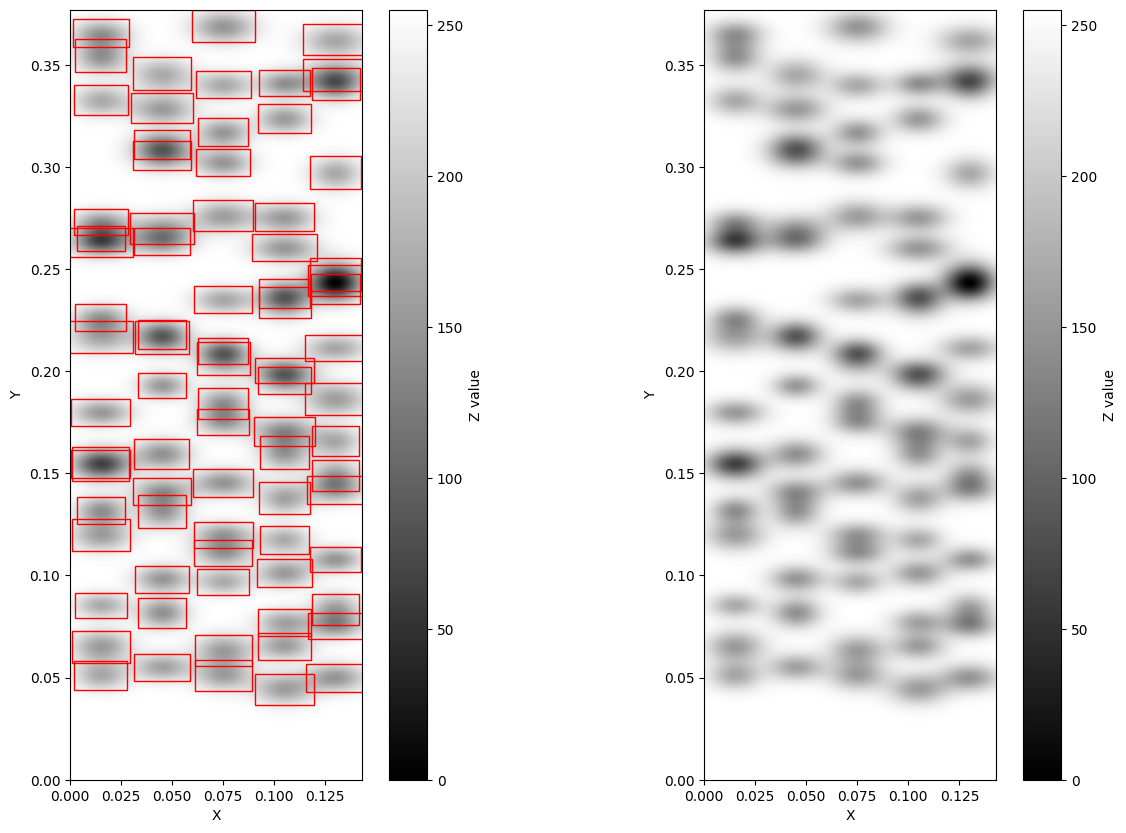

In [ ]:
# Plot ground truth labels
n_image = 3
labels_type = "Labelsv0_detect"
task = "detect"
image_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/gaussian_{n_image}.png"
label_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/{labels_type}/gaussian_{n_image}.txt"

fig, axs = plt.subplots(1, 2, figsize = (15, 10))
x, y, z = gaussians_labelled(image_path,
                   label_path,
                   axs[0],
                   task = task)

plot_grayscale(x, y, z, ax = axs[1])

In [ ]:
# Labels problem in Yolo
lines = load_label(label_path).split("\n")
# Step 2: Split each line into columns using spaces as the separator
labels = [line.split() for line in lines]
df_labels = pd.DataFrame(labels)

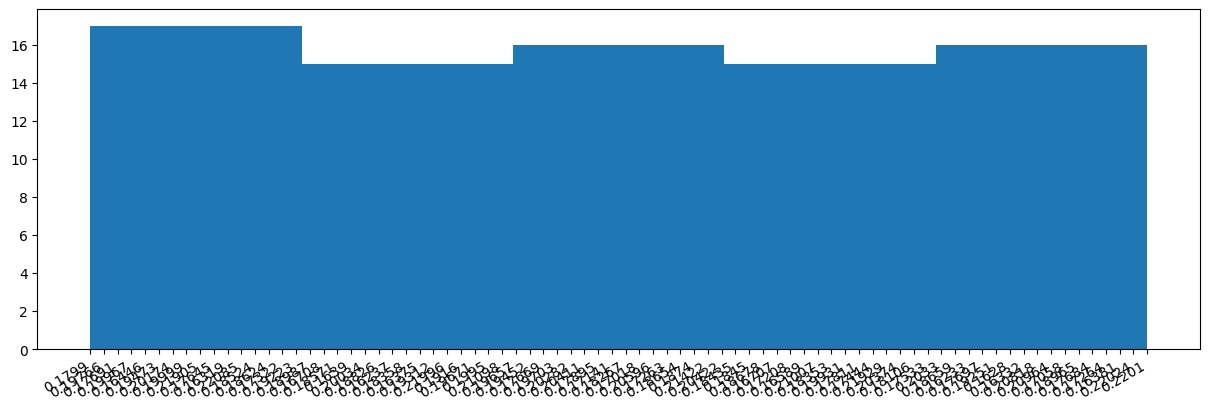

In [ ]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.hist(df_labels[[3]], bins = 5)
fig.autofmt_xdate()

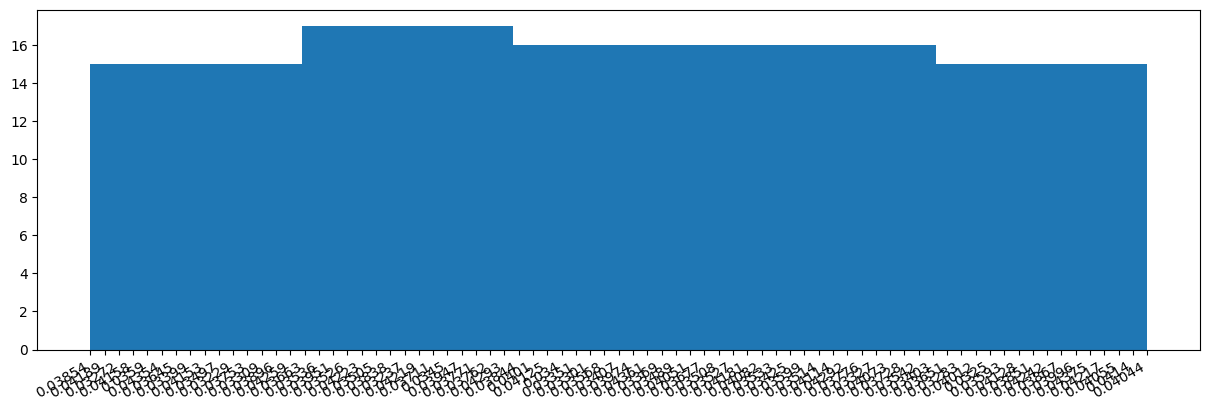

In [ ]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.hist(df_labels[[4]], bins = 5)
fig.autofmt_xdate()

### Image distribution

In [ ]:
"""
Image distribution for YoloV0
  - Images from 400 a 599
  - Labels without  gaussians with center out of the image
"""
labels_type = "Labelsv0_detect"
yolo_type = "YOLOv0_E3_detect"
yolo_folder = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{yolo_type}/datasets/"
images_folder = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/"
labels_folder= f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/{labels_type}/"
range_images = list(range(400, 600))
proportions = {'train': 0.7, 'val': 0.2, 'test': 0.1}

ppl_distribute_images_yolo(images_folder,
                           labels_folder,
                           yolo_folder,
                           range_images,
                           proportions)

In [ ]:
# Config Yolo model to train
yolo_folder = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{yolo_type}/"
yaml_content = (f'''
                train: {os.path.join(yolo_folder, "datasets/train/images")}
                val: {os.path.join(yolo_folder, "datasets/val/images")}
                test: {os.path.join(yolo_folder, "datasets/test/images")}
                names: ['gaussian']
                ''')

with open(os.path.join(yolo_folder,'data.yaml'), 'w') as f:
    f.write(yaml_content)

### Training model - YOLOv0

In [ ]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.154 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.6/78.2 GB disk)


In [ ]:
# Load nano model
model = YOLO("yolov8s.pt") # "yolov8s-seg.pt"

100%|██████████| 21.5M/21.5M [00:00<00:00, 71.1MB/s]


In [ ]:
# Train
model_name = "YOLOv0_E3_detect"
yolo_folder = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{model_name}"
results = model.train(
        device = 0, # "cpu"
        batch = -1,
        patience = 100,
        task = "detect",
        data = os.path.join(yolo_folder,'data.yaml'),
        epochs = 100,
    )

New https://pypi.org/project/ultralytics/8.0.158 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.154 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/YOLOv0_E3_detect/data.yaml, epochs=100, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None,

In [ ]:
# Copy results
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
shutil.copytree(Path("/content/runs/"), Path(f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{model_name}/runs/{timestamp}"))

NameError: ignored

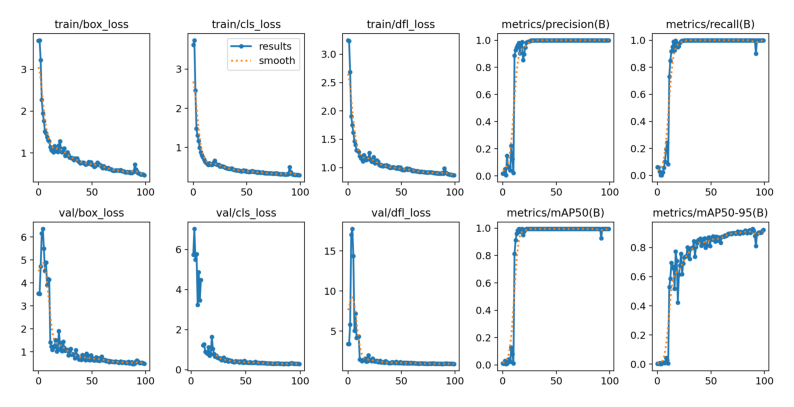

In [ ]:
task = "detect"
plotting.plot_results(f'/content/runs/{task}/train/results.csv')
image = Image.open(f'/content/runs/{task}/train/results.png')
fig = plt.figure(figsize = (10, 8))
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()

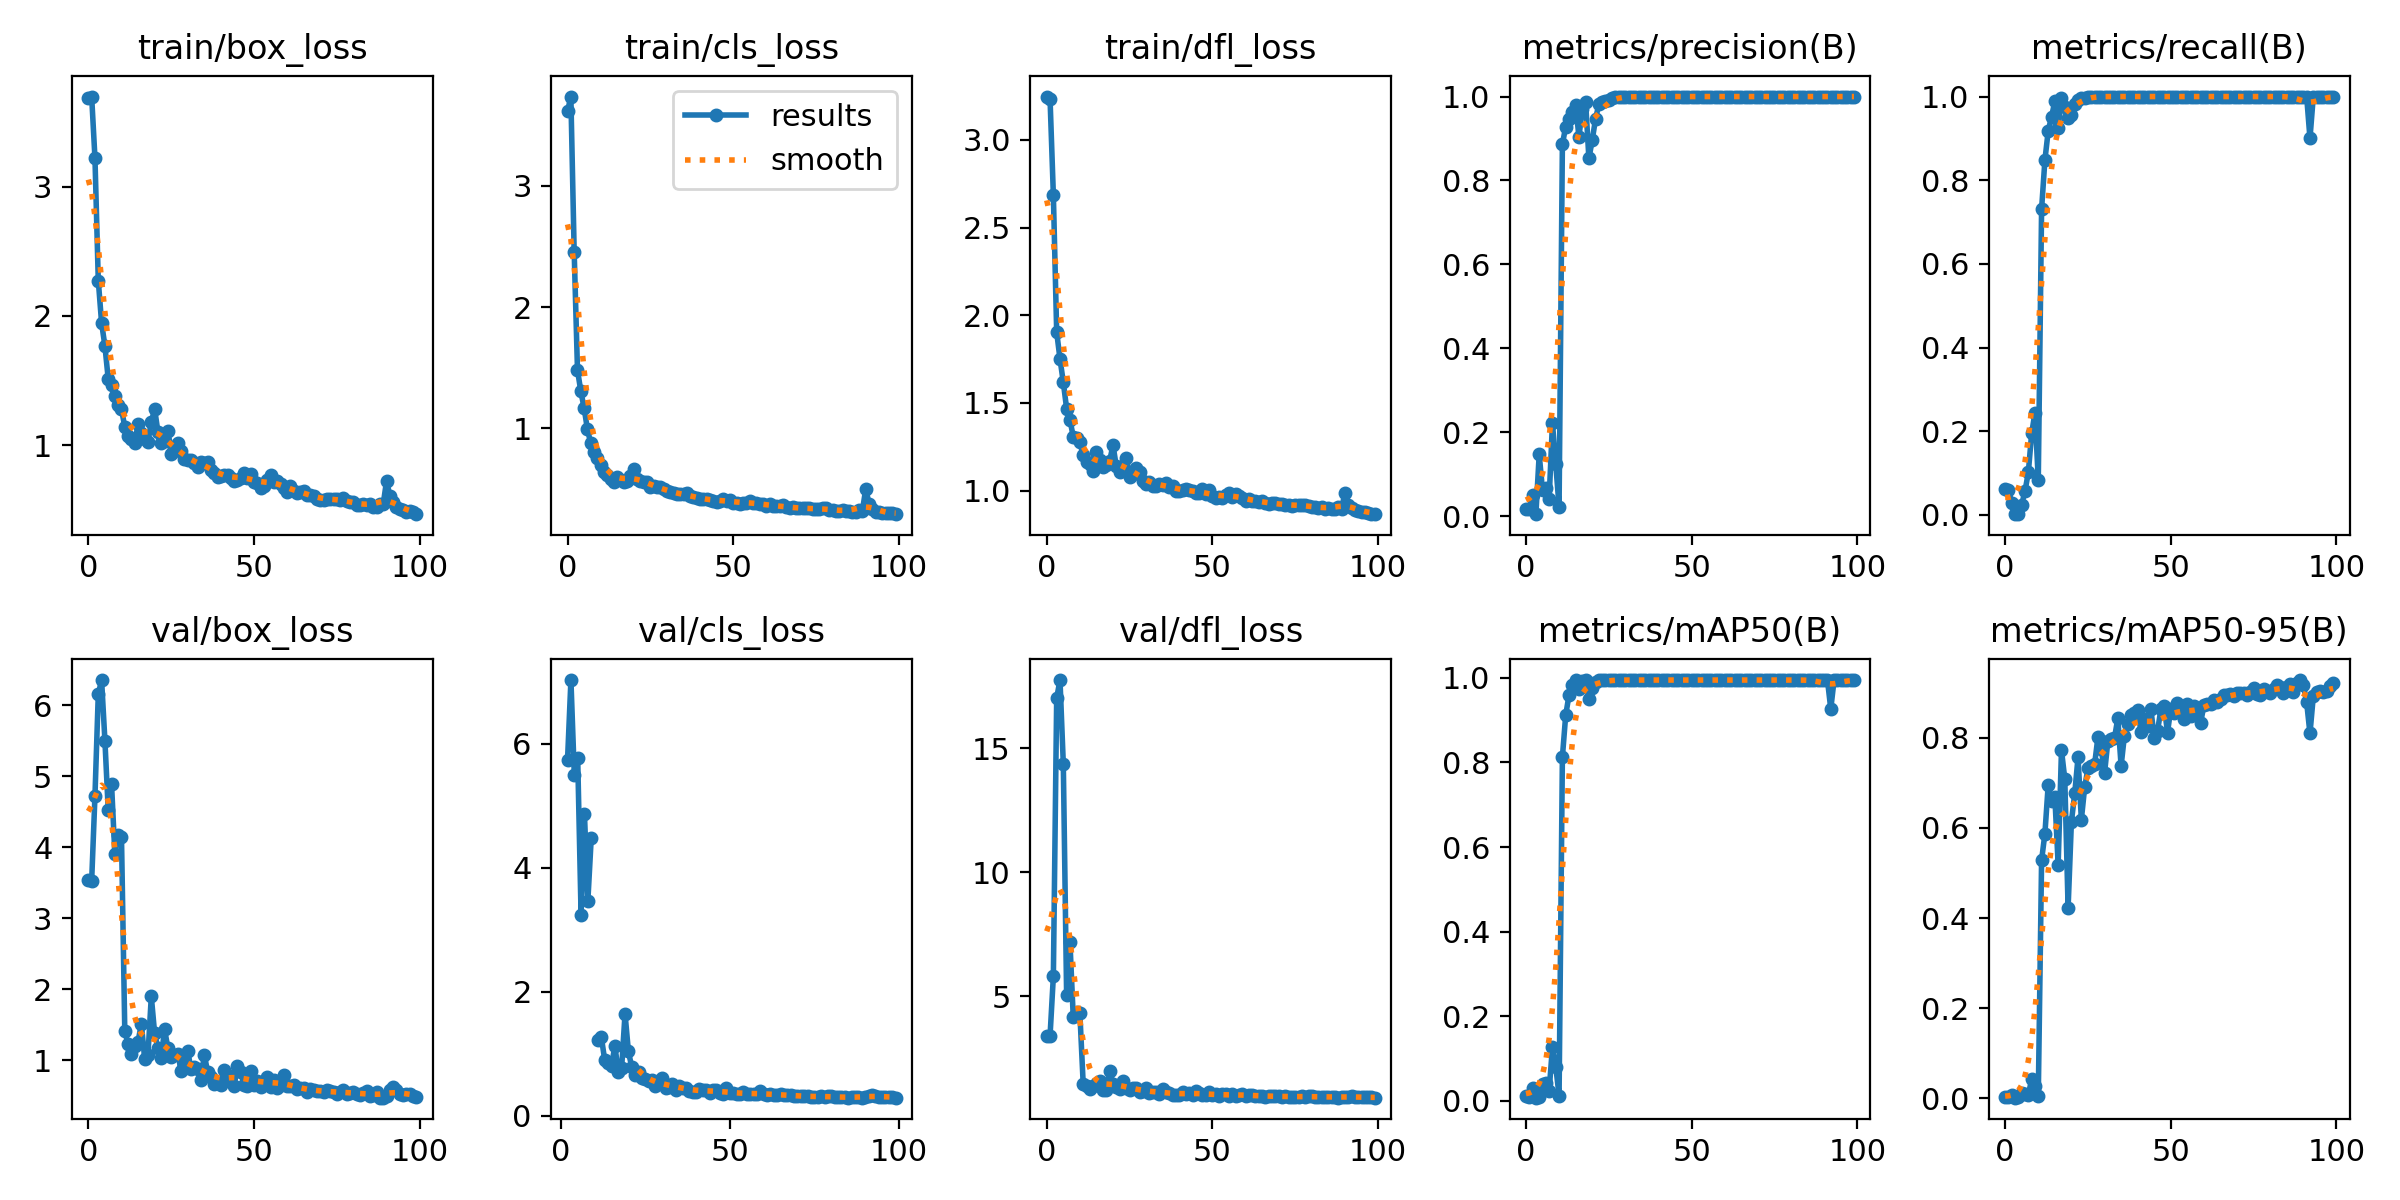

In [ ]:
image

### Predict with custom model - YOLOv0

In [31]:
os.listdir("/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models")

['YOLOv0_detect',
 'YOLOv0_E2_detect',
 'YOLOv0_E3_detect',
 'YOLOv0_E12_detect',
 'YOLOv0_E4_detect',
 'Archive',
 'YOLOv0_E1_detect',
 'YOLOv0_T80kenji_detect']

In [32]:
os.listdir("/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/YOLOv0_E3_detect/datasets/test/images/")

['gaussian_533.png',
 'gaussian_578.png',
 'gaussian_591.png',
 'gaussian_401.png',
 'gaussian_513.png',
 'gaussian_566.png',
 'gaussian_451.png',
 'gaussian_598.png',
 'gaussian_518.png',
 'gaussian_492.png',
 'gaussian_501.png',
 'gaussian_461.png',
 'gaussian_473.png',
 'gaussian_435.png',
 'gaussian_414.png',
 'gaussian_467.png',
 'gaussian_491.png',
 'gaussian_502.png',
 'gaussian_454.png',
 'gaussian_423.png']

In [33]:
n_image = 401 # 109 a anterior
image_ranges = [(0, 0.143), (0, 0.377)]
image_size = [143, 377]

labels_type = "Labelsv0_detect"
task = "detect"
model_name = "YOLOv0_E3_detect"
date_train = "2023-08-21_10-25-30"

image_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/gaussian_{n_image}.png"
label_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/{labels_type}/gaussian_{n_image}.txt"

# Load our custom model
model = YOLO(f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{model_name}/runs/{date_train}/{task}/train/weights/best.pt")

In [34]:
# Make the prediction
img = cv2.imread(image_path)
results = model.predict(img)

# class 0 boxes
tensor_boxes = results[0].boxes.xyxy

# Centers
means_yolo = [(float(x),
          float(y)) for
          x,y in zip(results[0].boxes.xywhn[:, 0] * image_size[0],
                     results[0].boxes.xywhn[:, 1]  * image_size[1])]


0: 640x256 85 gaussians, 669.5ms
Speed: 20.1ms preprocess, 669.5ms inference, 35.8ms postprocess per image at shape (1, 3, 640, 256)


Number of indentifiable Gaussians (center in the image): 79


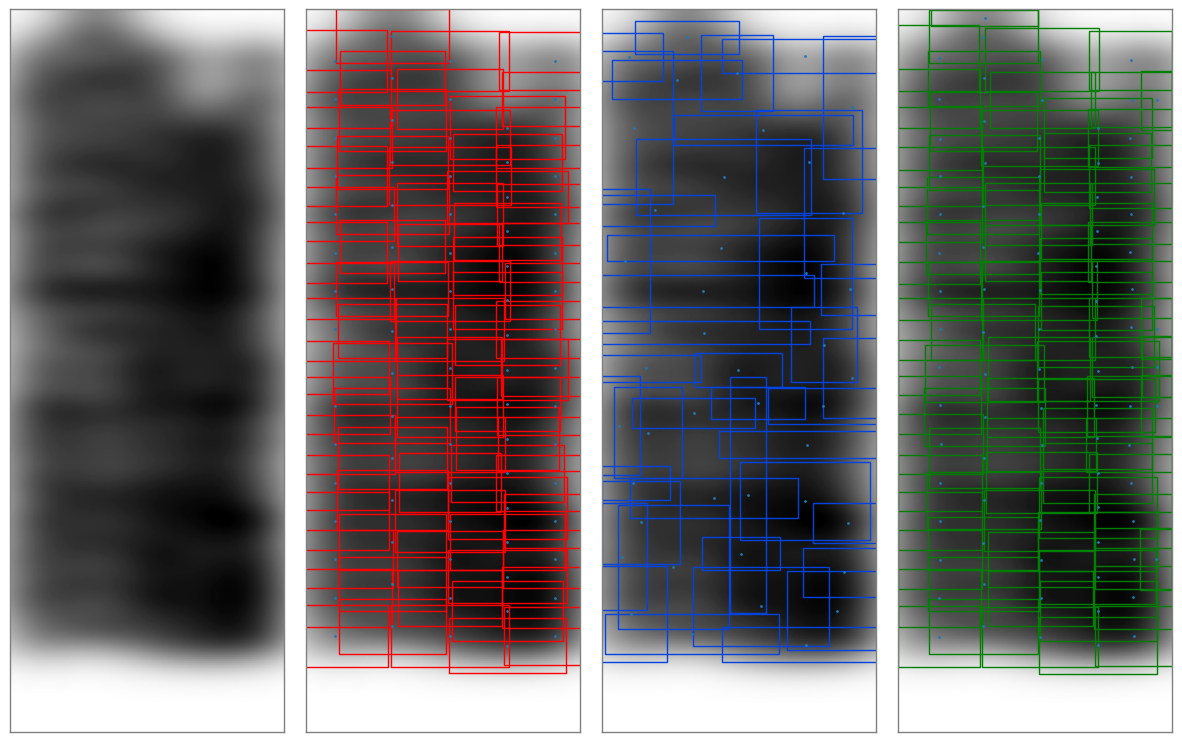

In [35]:
# Open the image file
im = Image.open(image_path)

# Create figure and axes
fig, axs = plt.subplots(1, 4, figsize = (15, 20))

# Display the image and plot predicted centers GMM
axs[2].imshow(im)
plot_boxes_gmm(means = means,
               covariances = covariances,
               ax = axs[2],
               beta = 3,
               edge_color = '#0343DF')
axs[2].set_ylim(ax.get_ylim()[::-1])
axs[2].scatter(means[:,0] * 1000, means[:, 1] * 1000, s = 1)
# axs[3].axis('off')
axs[2].set_xlim(0, 143)
axs[2].set_ylim(0, 377)


# Display the image and plot predicted centers
axs[3].imshow(im)
plot_boxes(tensor_boxes,
           axs[3],
           edge_color = 'g')
axs[3].set_ylim(axs[2].get_ylim()[::-1])
axs[3].scatter(np.array(means_yolo )[:,0], np.array(means_yolo)[:, 1], s = 1)
# axs[2].axis('off')
axs[3].set_xlim(0, 143)
axs[3].set_ylim(0, 377)

#axs[2].set_title("Prediction")

# Labelling
x, y, z = gaussians_labelled(image_path,
                   label_path,
                   axs[1],
                   task = task,
                   colorbar = False,
                   plot_centers = True)
# axs[1].axis('off')
axs[1].set_xlim(0, 0.143)
axs[1].set_ylim(0, 0.377)
#axs[1].set_title("Ground Truth")

# Image
plot_grayscale(x, y, z, colorbar = False, ax = axs[0])
# axs[0].axis('off')
axs[0].set_xlim(0, 0.143)
axs[0].set_ylim(0, 0.377)


for ax in axs:
  ax.xaxis.label.set_text("")
  ax.yaxis.label.set_text("")

  ax.set_xticks([])
  ax.set_yticks([])
  # Change the color of the axis spines (borders)
  for spine in ax.spines.values():
      spine.set_edgecolor('gray')
      spine.set_linewidth(1)

plt.subplots_adjust(wspace= 0.08)
plt.show()

### Error evaluation

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir("/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/YOLOv0_E3_detect/datasets/test/images/")
eval_images = [int(i.split('_')[1].split('.')[0]) for i in images_test] # Use the same images of the test from YOLO

In [ ]:
print(eval_images)

[533, 578, 591, 401, 513, 566, 451, 598, 518, 492, 501, 461, 473, 435, 414, 467, 491, 502, 454, 423]


In [ ]:
# Load our custom model
model_name = "YOLOv0_E3_detect"
task = "detect"
date_train = "2023-08-21_10-25-30"
model = YOLO(f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{model_name}/runs/{date_train}/{task}/train/weights/best.pt")

# Image root path
image_path = "/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/"

In [ ]:
# Iterate all images - GMM method
results = {'Image' : [],
           'Number identified - YOLO' : [],
           'Number identifiable - YOLO' : [],
           'Percentage - YOLO' : [],
           'RMSE_cx - YOLO' : [],
           'RMSE_cy - YOLO' : [],
           'RMSE_c - YOLO' : [],
           'RMSE_sigmax - YOLO' : [],
           'RMSE_sigmay - YOLO' : [],
           'RMSE_sigma - YOLO' : [],
           'MaxE_sigmax - YOLO': [],
           'MaxE_sigmay - YOLO': [],
           'MaxE_sigma - YOLO': [],
           'RMSE_amplitude - YOLO': [],
           'RMSEPixel - YOLO': []}

for n_image in eval_images:
  eval_gaussian = ppl_error_estimation(n_image,
                                       mat,
                                       estimation_method = "YOLO",
                                       image_path = image_path,
                                       yolo_model = model,
                                       covariance_gaussians_types = "diag",
                                       return_percentage = True)
  # Append values in the dictionary
  for key in results.keys():
      if key in eval_gaussian:
          results[key] += eval_gaussian[key]


0: 640x256 88 gaussians, 297.4ms
Speed: 3.8ms preprocess, 297.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.019857           0]
  [          0    0.014184]]]
covariances true [[[   0.025208           0]
  [          0    0.013856]]]



0: 640x256 85 gaussians, 241.8ms
Speed: 2.2ms preprocess, 241.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.02841           0]
  [          0    0.015058]]]
covariances true [[[   0.028472           0]
  [          0    0.014097]]]



0: 640x256 81 gaussians, 235.4ms
Speed: 2.0ms preprocess, 235.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.019632           0]
  [          0    0.015083]]]
covariances true [[[   0.026581           0]
  [          0    0.014967]]]



0: 640x256 85 gaussians, 236.1ms
Speed: 1.9ms preprocess, 236.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020113           0]
  [          0    0.013436]]]
covariances true [[[   0.026687           0]
  [          0       0.013]]]



0: 640x256 82 gaussians, 238.3ms
Speed: 4.2ms preprocess, 238.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.019206           0]
  [          0     0.01549]]]
covariances true [[[   0.026525           0]
  [          0    0.015438]]]



0: 640x256 82 gaussians, 242.4ms
Speed: 4.8ms preprocess, 242.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020567           0]
  [          0    0.013416]]]
covariances true [[[   0.026628           0]
  [          0    0.013286]]]



0: 640x256 82 gaussians, 1441.8ms
Speed: 6.9ms preprocess, 1441.8ms inference, 11.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01932           0]
  [          0    0.015397]]]
covariances true [[[   0.027244           0]
  [          0     0.01513]]]



0: 640x256 83 gaussians, 1317.8ms
Speed: 4.0ms preprocess, 1317.8ms inference, 8.6ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020195           0]
  [          0    0.015175]]]
covariances true [[[   0.029207           0]
  [          0    0.014956]]]



0: 640x256 84 gaussians, 936.9ms
Speed: 1.9ms preprocess, 936.9ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.018917           0]
  [          0    0.015168]]]
covariances true [[[   0.025066           0]
  [          0    0.015104]]]



0: 640x256 89 gaussians, 859.3ms
Speed: 1.9ms preprocess, 859.3ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.019516           0]
  [          0    0.014899]]]
covariances true [[[   0.025824           0]
  [          0    0.014366]]]



0: 640x256 82 gaussians, 411.0ms
Speed: 2.0ms preprocess, 411.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.02036           0]
  [          0      0.0152]]]
covariances true [[[   0.029185           0]
  [          0    0.015094]]]



0: 640x256 83 gaussians, 393.5ms
Speed: 2.0ms preprocess, 393.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.019429           0]
  [          0    0.015199]]]
covariances true [[[   0.027597           0]
  [          0    0.015262]]]



0: 640x256 83 gaussians, 332.0ms
Speed: 2.8ms preprocess, 332.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.029196           0]
  [          0    0.014208]]]
covariances true [[[   0.029643           0]
  [          0    0.013242]]]



0: 640x256 83 gaussians, 245.7ms
Speed: 1.5ms preprocess, 245.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020739           0]
  [          0    0.013973]]]
covariances true [[[    0.02865           0]
  [          0    0.013551]]]



0: 640x256 83 gaussians, 233.5ms
Speed: 2.1ms preprocess, 233.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.019564           0]
  [          0    0.014294]]]
covariances true [[[   0.028288           0]
  [          0    0.014184]]]



0: 640x256 84 gaussians, 394.1ms
Speed: 2.0ms preprocess, 394.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020036           0]
  [          0    0.013834]]]
covariances true [[[    0.02559           0]
  [          0    0.013789]]]



0: 640x256 84 gaussians, 400.2ms
Speed: 1.9ms preprocess, 400.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020398           0]
  [          0    0.015234]]]
covariances true [[[   0.027806           0]
  [          0    0.014778]]]



0: 640x256 88 gaussians, 387.7ms
Speed: 1.9ms preprocess, 387.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.019045           0]
  [          0    0.014896]]]
covariances true [[[   0.025469           0]
  [          0    0.013943]]]



0: 640x256 83 gaussians, 254.4ms
Speed: 1.9ms preprocess, 254.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020512           0]
  [          0    0.013606]]]
covariances true [[[   0.025673           0]
  [          0    0.013175]]]



0: 640x256 85 gaussians, 250.3ms
Speed: 1.9ms preprocess, 250.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020668           0]
  [          0    0.013241]]]
covariances true [[[   0.026166           0]
  [          0    0.012974]]]


In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[['mean', 'std', 'max']].T

mean        std        max
Image                          120.20      50.49     194.00
Number identified - YOLO        75.45       1.79      78.00
Number identifiable - YOLO      78.60       0.75      80.00
Percentage - YOLO               96.01       2.65     100.00
RMSE_cx - YOLO                   1.36       1.28       5.67
RMSE_cy - YOLO                   0.31       0.35       1.33
RMSE_c - YOLO                    1.40       1.32       5.82
RMSE_sigmax - YOLO               2.78       0.38       3.47
RMSE_sigmay - YOLO               3.30       0.76       4.76
RMSE_sigma - YOLO                4.33       0.77       5.90
MaxE_sigmax - YOLO              12.95       3.80      23.17
MaxE_sigmay - YOLO              31.74      22.01      72.79
MaxE_sigma - YOLO               34.89      21.32      73.88
RMSE_amplitude - YOLO           26.37       4.83      36.88
RMSEPixel - YOLO            626535.03  185681.17  921014.50

In [ ]:
# Results
pd.DataFrame.from_dict(results).round(2).sort_values('Image')

Image  Number identified - YOLO  Number identifiable - YOLO  \
3     401                        85                          79   
14    414                        83                          79   
19    423                        85                          79   
13    435                        83                          79   
6     451                        82                          79   
18    454                        83                          79   
11    461                        83                          79   
15    467                        84                          79   
12    473                        83                          79   
16    491                        84                          79   
9     492                        89                          79   
10    501                        82                          79   
17    502                        88                          79   
4     513                        82                          79   
8     518                        84                          79   
0     533                        88                          79   
5     566                        82                          79   
1     578                        85                          79   
2     591                        81                          79   
7     598                        83                          79   

    Percentage - YOLO  RMSE_cx - YOLO  RMSE_cy - YOLO  RMSE_c - YOLO  \
3              107.59           10.61            0.21          10.61   
14             105.06           11.19            0.19          11.19   
19             107.59           10.67            0.23          10.67   
13             105.06           10.95            0.24          10.95   
6              103.80           10.71            0.23          10.71   
18             105.06           10.75            0.22          10.75   
11             105.06           10.60            0.21          10.60   
15             106.33           10.45            0.22          10.45   
12             105.06           10.81            0.19          10.82   
16             106.33           10.97            0.21          10.97   
9              112.66           10.52            0.18          10.52   
10             103.80           10.77            0.24          10.77   
17             111.39           10.23            0.16          10.23   
4              103.80           10.84            0.16          10.84   
8              106.33           10.19            0.21          10.19   
0              111.39           10.56            0.20          10.56   
5              103.80           10.58            0.20          10.59   
1              107.59           10.71            0.24          10.72   
2              102.53           10.37            0.18          10.37   
7              105.06           10.65            0.19          10.65   

    RMSE_sigmax - YOLO  RMSE_sigmay - YOLO  RMSE_sigma - YOLO  \
3                15.13                3.80              15.60   
14               14.19                3.73              14.67   
19               14.43                3.74              14.91   
13               13.55                3.52              14.00   
6                13.34                3.48              13.79   
18               13.38                3.42              13.81   
11               13.71                3.29              14.10   
15               14.09                3.57              14.54   
12               13.41                3.59              13.88   
16               14.20                3.72              14.68   
9                16.94                4.13              17.43   
10               12.71                3.35              13.14   
17               15.13                3.54              15.54   
4                11.95                3.25              12.38   
8                14.52                3.45              14.93   
0                16.04                3.56 

In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(snapshot_folder_path = snapshot_folder_path,
                 error_dataframe = pd.DataFrame.from_dict(results).sort_values('Image'),
                 annotation = f"""Amplitudes estimated using the center directly\n
                 image_path = {image_path}\n
                 id_estimation_method = {model.__dict__['ckpt_path']}\n
                 id_images evaluated: {eval_images}""",
                 name = "E3YOLO")

## [ESTIMATION] Pipeline ppl_SCIKIT_PX
- Center estimation using SCIKIT / Yolo
- FWHM estimation using the density distribution

In [ ]:
# Load data
n_image = 409
image_ranges = [(0, 0.143), (0, 0.377)]
image_size = [143, 377]

# Generate GRID
x, y = generate_grid((0, image_ranges[0][-1]),
                     (0, image_ranges[1][-1]),
                     image_size[0],
                     image_size[1])

# Image - z intensities
image = [x, y, mat['F_data'][:,:, n_image]]

# Parameters extraction
(amplitude,
 xs,
 ys,
 dispersion_x,
 dispersion_y) = parameters_extract(mat['Fit_flux'], n_image)

In [ ]:
# Predict Gaussian centers
# nonzero_pairs, center_coordinates = estimate_gaussians_centers(image,
#                                                      peak_method = 'laplace')

In [ ]:
# Predict Yolo
labels_type = "Labelsv0_detect"
task = "detect"
model_name = "YOLOv0_E3_detect"
date_train = "2023-08-21_10-25-30"

image_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/gaussian_{n_image}.png"
label_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/{labels_type}/gaussian_{n_image}.txt"

# Load our custom model
model = YOLO(f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{model_name}/runs/{date_train}/{task}/train/weights/best.pt")

(means,
 covariances,
 amplitudes_yolo) = ppl_yolo_predict_gaussians(mat,
                                               n_image,
                                               model,
                                               image_path,
                                               image_ranges = image_ranges,
                                               image_size = image_size)


0: 640x256 84 gaussians, 418.5ms
Speed: 5.5ms preprocess, 418.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


In [ ]:
# Yolo and refining center and dispersion (Max Amp. and PX)
(converted_new_means,
new_covariances,
amplitudes_px,
new_means,
new_covariances_up,
new_covariances_down) = ppl_yolo_px_predict_gaussians(mat,
                                                      n_image,
                                                      model,
                                                      image_path,
                                                      px_step_size = 3)


0: 640x256 84 gaussians, 243.3ms
Speed: 2.5ms preprocess, 243.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


In [ ]:
# Yolo and refining center and dispersion (Max Amp. and PX)
(converted_new_means_infer,
new_covariances_infer,
amplitudes_px_infer,
new_means_infer,
new_covariances_up_infer,
new_covariances_down_infer) = ppl_yolo_px_predict_gaussians(mat,
                                                            n_image,
                                                            model,
                                                            image_path,
                                                            px_step_size = 3,
                                                            infer_overlapping = True)


0: 640x256 84 gaussians, 258.5ms
Speed: 3.2ms preprocess, 258.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


### Study - covariances overlapping

In [ ]:
# Flag potential hard overlappings (negative relation of amplitudes)
# Hard overlappings = the peak of one Gaussians is really close to another one
overlap_ups_x = [i[0][0] < 0 for i in new_covariances_up] # Right
overlap_downs_x = [i[0][0] < 0 for i in new_covariances_down] # Left
overlap_ups_y = [i[1][1] < 0 for i in new_covariances_up]
overlap_downs_y = [i[1][1] < 0 for i in new_covariances_down]

# Print probable overlappings
print(f'overlap up x : {np.sum(np.array(overlap_ups_x))}')
print(f'overlap down x : {np.sum(np.array(overlap_downs_x))}')
print(f'overlap up y : {np.sum(np.array(overlap_ups_y))}')
print(f'overlap down y : {np.sum(np.array(overlap_downs_y))}')

overlap up x : 0
overlap down x : 1
overlap up y : 8
overlap down y : 13


In [ ]:
# Difference of covariance up and down
diffs_cov_x = [i[0][0] - j[0][0] for (i, j) in zip(new_covariances_up,
                                                   new_covariances_down)]
diffs_cov_y = [i[1][1] - j[1][1] for (i, j) in zip(new_covariances_up,
                                                   new_covariances_down)]

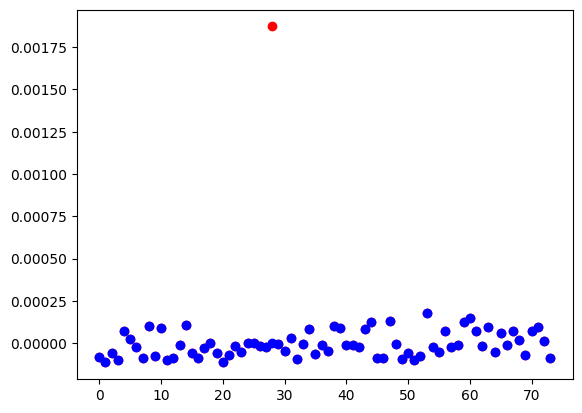

In [ ]:
# Check outlier
diffs_x_onmargin = remove_outliers_using_iqr(diffs_cov_x)
plt.scatter(range(len(diffs_cov_x)), diffs_cov_x, color = 'red')
plt.scatter(range(len(diffs_cov_x)),np.multiply(np.array(diffs_cov_x), np.array(diffs_x_onmargin).astype(int)), color = 'blue')

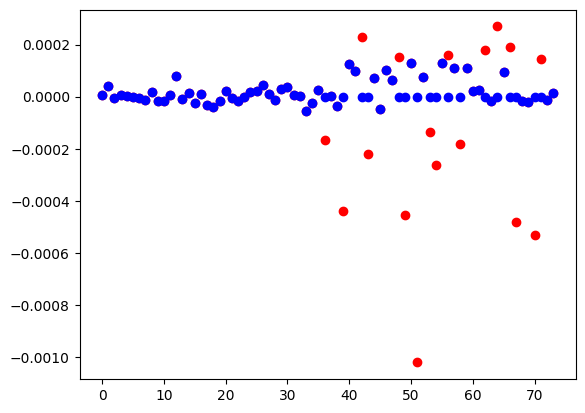

In [ ]:
a# Check outlier
diffs_y_onmargin = remove_outliers_using_iqr(diffs_cov_y)
plt.scatter(range(len(diffs_cov_y)), diffs_cov_y, color = 'red')
plt.scatter(range(len(diffs_cov_y)),np.multiply(np.array(diffs_cov_y),
                                                np.array(diffs_y_onmargin).astype(int)), color = 'blue')

In [ ]:
# OK - integrar no pipeline
new_covariances_modified = replace_covariances_outlier(new_covariances.copy(),
                                                       new_covariances_up,
                                                       new_covariances_down)

### Evaluate - Plot truth, YOLO and PX

In [ ]:
# Create subplots
plt.ioff()
fig, ax = plt.subplots(1, figsize = (25, 20))
all_texts = []

In [ ]:
# Original image
plot_grayscale(x, y, mat['F_data'][:,:, n_image],
               colorbar = False,
               ax = ax)

In [ ]:
# Plot box and center - from pipeline with PX estimation covariance
all_texts = all_texts + plot_box_labels(image,
                                  [(x, y) for x, y in converted_new_means],
                                  [(wx, wy) for wx, wy in
                                   zip(np.sqrt(new_covariances[:, 0, 0]),
                                       np.sqrt(new_covariances[:, 1, 1]))],
                                  ax = ax,
                                  center_color = 'b', # CENTER COLOR
                                  annotate_gaussians = True,
                                  text_color = 'blue')

In [ ]:
# Plot box and center - TRUE
all_texts = all_texts + plot_box_labels(image,
                                        list(zip(xs, ys)),
                                        list(zip(dispersion_x, dispersion_y)),
                                        ax = ax,
                                        box_edge_color = 'g', # BOX COLOR
                                        center_color = 'g', # CENTER COLOR
                                        annotate_gaussians = True)

In [ ]:
# Plot box and center - YOLO
image_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/gaussian_{n_image}.png"
task = "detect"
model_name = "YOLOv0_E3_detect"
date_train = "2023-08-21_10-25-30"

# Load our custom model
model = YOLO(f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{model_name}/runs/{date_train}/{task}/train/weights/best.pt")

# Predict
(means,
 covariances,
 amplitudes) = ppl_yolo_predict_gaussians(mat,
                                          n_image,
                                          model,
                                          image_path,
                                          image_ranges = image_ranges,
                                          image_size = image_size)

# Plot box and center
plot_box_labels(image,
                [(x, y) for x, y in means],
                [(wx, wy) for wx, wy in
                  zip(np.sqrt(covariances[:, 0, 0]),
                      np.sqrt(covariances[:, 1, 1]))],
                ax = ax,
                box_edge_color = 'b', # BOX COLOR
                center_color = 'red', # CENTER COLOR
                annotate_gaussians = False)


0: 640x256 84 gaussians, 299.3ms
Speed: 1.7ms preprocess, 299.3ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 256)


In [ ]:
adjust_text(all_texts)

9

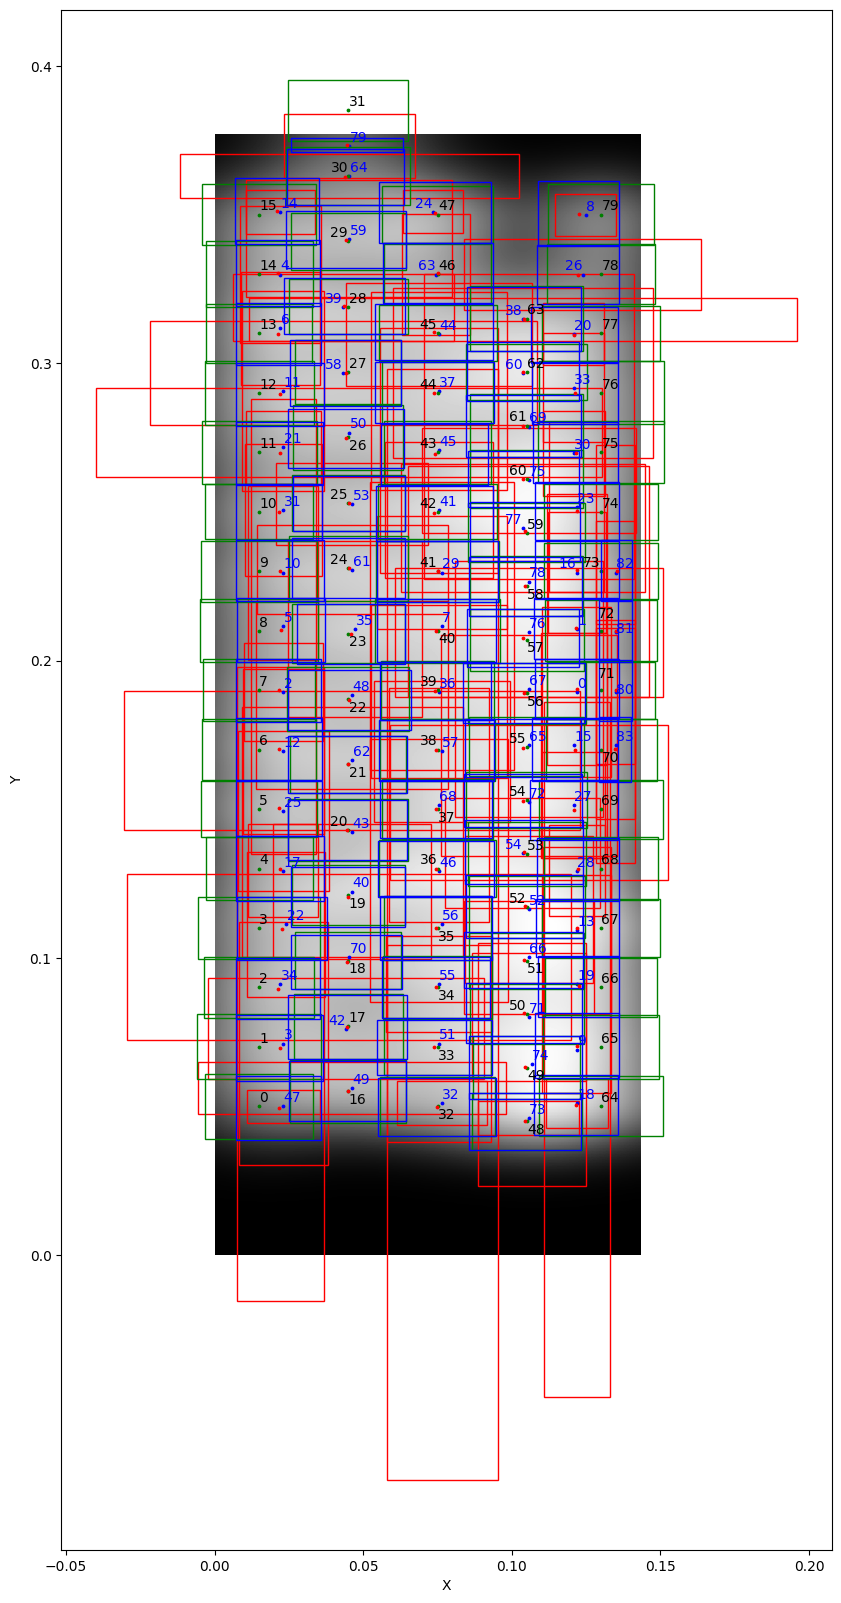

In [ ]:
plt.ion()
plt.show()

### Error evaluation - PX

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir("/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/YOLOv0_E3_detect/datasets/test/images/")
eval_images = [int(i.split('_')[1].split('.')[0]) for i in images_test] # Use the same images of the test from YOLO

In [ ]:
print(eval_images)

[533, 578, 591, 401, 513, 566, 451, 598, 518, 492, 501, 461, 473, 435, 414, 467, 491, 502, 454, 423]


In [ ]:
# Load our custom model
model_name = "YOLOv0_E3_detect"
date_train = "2023-08-21_10-25-30"

task = "detect"
model = YOLO(f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{model_name}/runs/{date_train}/{task}/train/weights/best.pt")

# Image root path
image_path = "/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/"

In [ ]:
# Iterate all images - GMM method
results = {'Image' : [],
           'Number identified - YOLO_px' : [],
           'Number identifiable - YOLO_px' : [],
           'Percentage - YOLO_px' : [],
           'RMSE_cx - YOLO_px' : [],
           'RMSE_cy - YOLO_px' : [],
           'RMSE_c - YOLO_px' : [],
           'RMSE_sigmax - YOLO_px' : [],
           'RMSE_sigmay - YOLO_px' : [],
           'RMSE_sigma - YOLO_px' : [],
           'MaxE_sigmax - YOLO_px': [],
           'MaxE_sigmay - YOLO_px': [],
           'MaxE_sigma - YOLO_px': [],
           'RMSE_amplitude - YOLO_px': [],
           'RMSEPixel - YOLO_px': []}

for n_image in eval_images:
  eval_gaussian = ppl_error_estimation(n_image,
                                       mat,
                                       estimation_method = "YOLO_px",
                                       image_path = image_path,
                                       yolo_model = model,
                                       covariance_gaussians_types = "diag",
                                       return_percentage = True)
  # Append values in the dictionary
  for key in results.keys():
      if key in eval_gaussian:
          results[key] += eval_gaussian[key]


0: 640x256 88 gaussians, 599.4ms
Speed: 2.2ms preprocess, 599.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.017826           0]
  [          0    0.019502]]]
covariances true [[[   0.025208           0]
  [          0    0.013856]]]



0: 640x256 85 gaussians, 415.1ms
Speed: 2.0ms preprocess, 415.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.012955           0]
  [          0   0.0094759]]]
covariances true [[[   0.028472           0]
  [          0    0.014097]]]



0: 640x256 81 gaussians, 464.3ms
Speed: 2.0ms preprocess, 464.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.014784           0]
  [          0     0.04339]]]
covariances true [[[   0.026581           0]
  [          0    0.014967]]]



0: 640x256 85 gaussians, 479.6ms
Speed: 2.3ms preprocess, 479.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016613           0]
  [          0    0.022448]]]
covariances true [[[   0.026687           0]
  [          0       0.013]]]



0: 640x256 82 gaussians, 617.8ms
Speed: 2.9ms preprocess, 617.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.015537           0]
  [          0     0.11685]]]
covariances true [[[   0.026525           0]
  [          0    0.015438]]]



0: 640x256 82 gaussians, 372.6ms
Speed: 1.9ms preprocess, 372.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.014831           0]
  [          0    0.019934]]]
covariances true [[[   0.026628           0]
  [          0    0.013286]]]



0: 640x256 82 gaussians, 375.6ms
Speed: 3.6ms preprocess, 375.6ms inference, 8.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.015816           0]
  [          0     0.14678]]]
covariances true [[[   0.027244           0]
  [          0     0.01513]]]



0: 640x256 83 gaussians, 395.1ms
Speed: 1.9ms preprocess, 395.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015544           0]
  [          0     0.04375]]]
covariances true [[[   0.029207           0]
  [          0    0.014956]]]



0: 640x256 84 gaussians, 395.6ms
Speed: 2.0ms preprocess, 395.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015753           0]
  [          0    0.058006]]]
covariances true [[[   0.025066           0]
  [          0    0.015104]]]



0: 640x256 89 gaussians, 364.7ms
Speed: 2.6ms preprocess, 364.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.017401           0]
  [          0     0.06325]]]
covariances true [[[   0.025824           0]
  [          0    0.014366]]]



0: 640x256 82 gaussians, 234.7ms
Speed: 2.0ms preprocess, 234.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.014262           0]
  [          0    0.040412]]]
covariances true [[[   0.029185           0]
  [          0    0.015094]]]



0: 640x256 83 gaussians, 238.1ms
Speed: 2.1ms preprocess, 238.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.018042           0]
  [          0    0.061691]]]
covariances true [[[   0.027597           0]
  [          0    0.015262]]]



0: 640x256 83 gaussians, 408.5ms
Speed: 1.9ms preprocess, 408.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013425           0]
  [          0    0.010802]]]
covariances true [[[   0.029643           0]
  [          0    0.013242]]]



0: 640x256 83 gaussians, 400.8ms
Speed: 1.9ms preprocess, 400.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.019762           0]
  [          0    0.018935]]]
covariances true [[[    0.02865           0]
  [          0    0.013551]]]



0: 640x256 83 gaussians, 425.3ms
Speed: 4.8ms preprocess, 425.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016188           0]
  [          0    0.039202]]]
covariances true [[[   0.028288           0]
  [          0    0.014184]]]



0: 640x256 84 gaussians, 415.4ms
Speed: 2.0ms preprocess, 415.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.018737           0]
  [          0    0.067357]]]
covariances true [[[    0.02559           0]
  [          0    0.013789]]]



0: 640x256 84 gaussians, 316.4ms
Speed: 1.8ms preprocess, 316.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.018149           0]
  [          0    0.043053]]]
covariances true [[[   0.027806           0]
  [          0    0.014778]]]



0: 640x256 88 gaussians, 229.5ms
Speed: 2.6ms preprocess, 229.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014386           0]
  [          0    0.026032]]]
covariances true [[[   0.025469           0]
  [          0    0.013943]]]



0: 640x256 83 gaussians, 235.9ms
Speed: 2.4ms preprocess, 235.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01676           0]
  [          0    0.022481]]]
covariances true [[[   0.025673           0]
  [          0    0.013175]]]



0: 640x256 85 gaussians, 237.1ms
Speed: 1.9ms preprocess, 237.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016568           0]
  [          0    0.018677]]]
covariances true [[[   0.026166           0]
  [          0    0.012974]]]


In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[['mean', 'std', 'max']].T

mean         std          max
Image                               493.10       58.18       598.00
Number identified - YOLO_px          83.95        2.19        89.00
Number identifiable - YOLO_px        79.00        0.00        79.00
Percentage - YOLO_px                106.26        2.77       112.66
RMSE_cx - YOLO_px                    12.67        0.34        13.28
RMSE_cy - YOLO_px                     0.71        0.04         0.80
RMSE_c - YOLO_px                     12.69        0.34        13.30
RMSE_sigmax - YOLO_px                71.47       15.08        98.78
RMSE_sigmay - YOLO_px               161.26       20.28       189.74
RMSE_sigma - YOLO_px                177.04       19.97       204.23
MaxE_sigmax - YOLO_px              1057.24      954.99      3237.41
MaxE_sigmay - YOLO_px              1469.07      942.52      4135.30
MaxE_sigma - YOLO_px               1944.34     1126.62      4234.54
RMSE_amplitude - YOLO_px            100.68        2.23       105.09
RMSEPixel - YOLO_px            29045185.62  2442421.88  33216569.94

In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(snapshot_folder_path = snapshot_folder_path,
                 error_dataframe = pd.DataFrame.from_dict(results).sort_values('Image'),
                 annotation = f"""Amplitudes estimated using the center directly\n
                 image_path = {image_path}\n
                 id_estimation_method = {model.__dict__['ckpt_path']}\n
                 id_images evaluated: {eval_images}""",
                 name = "E3YOLOPX")

## Evaluate - Plot Truth, YOLO and PX infer

In [ ]:
# Create subplots
plt.ioff()
fig, ax = plt.subplots(1, figsize = (25, 20))
all_texts = []

In [ ]:
# Original image
plot_grayscale(x, y, mat['F_data'][:,:, n_image],
               colorbar = False,
               ax = ax)

In [ ]:
# Plot box and center - from pipeline with PX estimation covariance
all_texts = all_texts + plot_box_labels(image,
                                  [(x, y) for x, y in converted_new_means_infer],
                                  [(wx, wy) for wx, wy in
                                   zip(np.sqrt(new_covariances_infer[:, 0, 0]),
                                       np.sqrt(new_covariances_infer[:, 1, 1]))],
                                  ax = ax,
                                  center_color = 'b', # CENTER COLOR
                                  annotate_gaussians = True,
                                  text_color = 'blue')

In [ ]:
# Plot box and center - TRUE
all_texts = all_texts + plot_box_labels(image,
                                        list(zip(xs, ys)),
                                        list(zip(dispersion_x, dispersion_y)),
                                        ax = ax,
                                        box_edge_color = 'g', # BOX COLOR
                                        center_color = 'g', # CENTER COLOR
                                        annotate_gaussians = True)

In [ ]:
# Plot box and center -  YOLO
plot_box_labels(image,
                [(x, y) for x, y in means],
                [(wx, wy) for wx, wy in
                  zip(np.sqrt(covariances[:, 0, 0]),
                      np.sqrt(covariances[:, 1, 1]))],
                ax = ax,
                box_edge_color = 'b', # BOX COLOR
                center_color = 'red', # CENTER COLOR
                annotate_gaussians = False)

In [ ]:
adjust_text(all_texts)

6

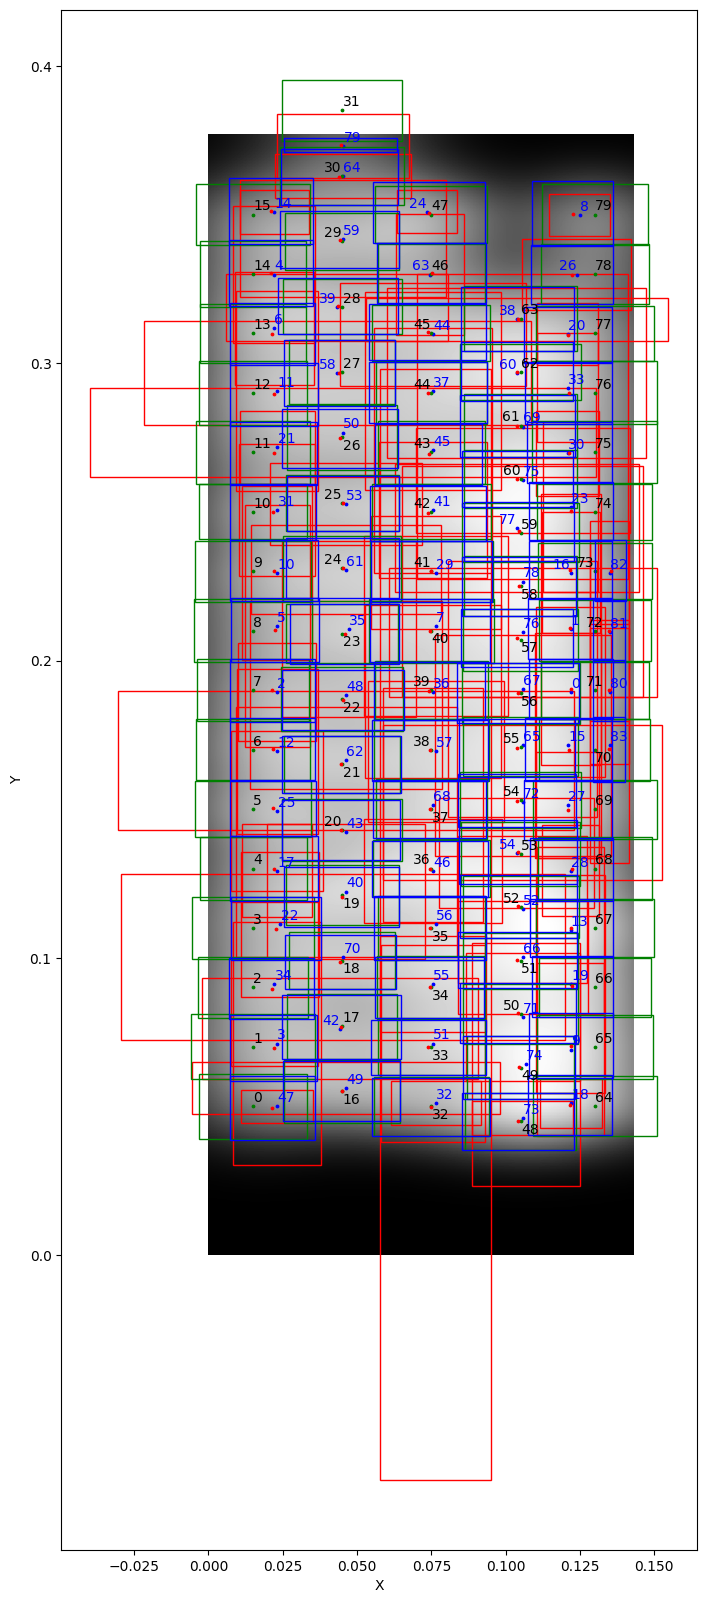

In [ ]:
plt.ion()
plt.show()

### Error evaluation - PX Infer

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir("/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/YOLOv0_E3_detect/datasets/test/images/")
eval_images = [int(i.split('_')[1].split('.')[0]) for i in images_test] # Use the same images of the test from YOLO

In [ ]:
print(eval_images)

[533, 578, 591, 401, 513, 566, 451, 598, 518, 492, 501, 461, 473, 435, 414, 467, 491, 502, 454, 423]


In [ ]:
# Load our custom model
model_name = "YOLOv0_E3_detect"
task = "detect"
date_train = "2023-08-21_10-25-30"

model = YOLO(f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{model_name}/runs/{date_train}/{task}/train/weights/best.pt")

# Image root path
image_path = "/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/"

In [ ]:
# Iterate all images - GMM method
results = {'Image' : [],
           'Number identified - YOLO_px_infer' : [],
           'Number identifiable - YOLO_px_infer' : [],
           'Percentage - YOLO_px_infer' : [],
           'RMSE_cx - YOLO_px_infer' : [],
           'RMSE_cy - YOLO_px_infer' : [],
           'RMSE_c - YOLO_px_infer' : [],
           'RMSE_sigmax - YOLO_px_infer' : [],
           'RMSE_sigmay - YOLO_px_infer' : [],
           'RMSE_sigma - YOLO_px_infer' : [],
           'MaxE_sigmax - YOLO_px_infer': [],
           'MaxE_sigmay - YOLO_px_infer': [],
           'MaxE_sigma - YOLO_px_infer': [],
           'RMSE_amplitude - YOLO_px_infer': [],
           'RMSEPixel - YOLO_px_infer': []}

for n_image in eval_images:
  eval_gaussian = ppl_error_estimation(n_image,
                                       mat,
                                       estimation_method = "YOLO_px_infer",
                                       image_path = image_path,
                                       yolo_model = model,
                                       covariance_gaussians_types = "diag",
                                       return_percentage = True)
  # Append values in the dictionary
  for key in results.keys():
      if key in eval_gaussian:
          results[key] += eval_gaussian[key]


0: 640x256 88 gaussians, 310.3ms
Speed: 2.2ms preprocess, 310.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.017826           0]
  [          0    0.019502]]]
covariances true [[[   0.025208           0]
  [          0    0.013856]]]



0: 640x256 85 gaussians, 243.2ms
Speed: 2.1ms preprocess, 243.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.012955           0]
  [          0   0.0094759]]]
covariances true [[[   0.028472           0]
  [          0    0.014097]]]



0: 640x256 81 gaussians, 245.0ms
Speed: 1.5ms preprocess, 245.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.014784           0]
  [          0     0.04339]]]
covariances true [[[   0.026581           0]
  [          0    0.014967]]]



0: 640x256 85 gaussians, 443.8ms
Speed: 3.1ms preprocess, 443.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016613           0]
  [          0    0.022448]]]
covariances true [[[   0.026687           0]
  [          0       0.013]]]



0: 640x256 82 gaussians, 578.4ms
Speed: 2.0ms preprocess, 578.4ms inference, 7.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.015537           0]
  [          0     0.11685]]]
covariances true [[[   0.026525           0]
  [          0    0.015438]]]



0: 640x256 82 gaussians, 487.8ms
Speed: 2.2ms preprocess, 487.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.014831           0]
  [          0    0.019934]]]
covariances true [[[   0.026628           0]
  [          0    0.013286]]]



0: 640x256 82 gaussians, 412.7ms
Speed: 2.7ms preprocess, 412.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.015816           0]
  [          0     0.14678]]]
covariances true [[[   0.027244           0]
  [          0     0.01513]]]



0: 640x256 83 gaussians, 381.9ms
Speed: 2.1ms preprocess, 381.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015544           0]
  [          0     0.04375]]]
covariances true [[[   0.029207           0]
  [          0    0.014956]]]



0: 640x256 84 gaussians, 240.3ms
Speed: 2.0ms preprocess, 240.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015753           0]
  [          0    0.058006]]]
covariances true [[[   0.025066           0]
  [          0    0.015104]]]



0: 640x256 89 gaussians, 233.6ms
Speed: 1.5ms preprocess, 233.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.017401           0]
  [          0    0.030196]]]
covariances true [[[   0.025824           0]
  [          0    0.014366]]]



0: 640x256 82 gaussians, 229.4ms
Speed: 1.5ms preprocess, 229.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.014262           0]
  [          0    0.040412]]]
covariances true [[[   0.029185           0]
  [          0    0.015094]]]



0: 640x256 83 gaussians, 237.4ms
Speed: 1.9ms preprocess, 237.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.018042           0]
  [          0    0.061691]]]
covariances true [[[   0.027597           0]
  [          0    0.015262]]]



0: 640x256 83 gaussians, 237.0ms
Speed: 3.0ms preprocess, 237.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013425           0]
  [          0    0.010802]]]
covariances true [[[   0.029643           0]
  [          0    0.013242]]]



0: 640x256 83 gaussians, 229.5ms
Speed: 2.5ms preprocess, 229.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.019762           0]
  [          0    0.018935]]]
covariances true [[[    0.02865           0]
  [          0    0.013551]]]



0: 640x256 83 gaussians, 226.7ms
Speed: 2.2ms preprocess, 226.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016188           0]
  [          0    0.039202]]]
covariances true [[[   0.028288           0]
  [          0    0.014184]]]



0: 640x256 84 gaussians, 248.8ms
Speed: 2.4ms preprocess, 248.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.018737           0]
  [          0    0.067357]]]
covariances true [[[    0.02559           0]
  [          0    0.013789]]]



0: 640x256 84 gaussians, 234.7ms
Speed: 4.3ms preprocess, 234.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.018149           0]
  [          0    0.043053]]]
covariances true [[[   0.027806           0]
  [          0    0.014778]]]



0: 640x256 88 gaussians, 230.7ms
Speed: 1.9ms preprocess, 230.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014386           0]
  [          0    0.026032]]]
covariances true [[[   0.025469           0]
  [          0    0.013943]]]



0: 640x256 83 gaussians, 230.8ms
Speed: 1.5ms preprocess, 230.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01676           0]
  [          0    0.022481]]]
covariances true [[[   0.025673           0]
  [          0    0.013175]]]



0: 640x256 85 gaussians, 241.8ms
Speed: 1.9ms preprocess, 241.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016568           0]
  [          0    0.018677]]]
covariances true [[[   0.026166           0]
  [          0    0.012974]]]


In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[['mean', 'std', 'max']].T

mean         std          max
Image                                     493.10       58.18       598.00
Number identified - YOLO_px_infer          83.95        2.19        89.00
Number identifiable - YOLO_px_infer        79.00        0.00        79.00
Percentage - YOLO_px_infer                106.26        2.77       112.66
RMSE_cx - YOLO_px_infer                    12.67        0.34        13.28
RMSE_cy - YOLO_px_infer                     0.71        0.04         0.80
RMSE_c - YOLO_px_infer                     12.69        0.34        13.30
RMSE_sigmax - YOLO_px_infer                61.58       11.88        94.48
RMSE_sigmay - YOLO_px_infer               132.21       16.45       159.29
RMSE_sigma - YOLO_px_infer                146.28       16.70       183.52
MaxE_sigmax - YOLO_px_infer               782.56      806.39      3237.41
MaxE_sigmay - YOLO_px_infer               924.67      691.93      3258.11
MaxE_sigma - YOLO_px_infer               1338.82      887.07      3295.22
RMSE_amplitude - YOLO_px_infer            100.68        2.23       105.09
RMSEPixel - YOLO_px_infer            25198208.78  1707608.62  28825949.06

In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(snapshot_folder_path = snapshot_folder_path,
                 error_dataframe = pd.DataFrame.from_dict(results).sort_values('Image'),
                 annotation = f"""Amplitudes estimated using the center directly\n
                 image_path = {image_path}\n
                 id_estimation_method = {model.__dict__['ckpt_path']}\n
                 id_images evaluated: {eval_images}""",
                 name = "E3YOLOPXINFER")

## [ESTIMATION] Pipeline ensembled (PX and YOLO)

In [ ]:
# Load data
n_image = 409

# Image - z intensities
image = [x,
         y,
         mat['F_data'][:,:, n_image]]

image_ranges = [(0, 0.143),
                (0, 0.377)]
image_size = [143, 377]

# Parameters extraction
(amplitude,
 xs,
 ys,
 dispersion_x,
 dispersion_y) = parameters_extract(mat['Fit_flux'], n_image)

#### ERROR MSEP evaluation - YOLO + Refinning -
- Compare values by reconstruction with the estimated parameters (per Gaussian)

##### Each Gaussian error estimation

In [ ]:
# Sanity check truth
means_truth = list(zip(xs, ys))
covariances_truth = [np.array([[(wx/(np.sqrt(2)))**2, 0],
                               [0, (wy/(np.sqrt(2)))**2]]) for
                     wx, wy in zip(dispersion_x, dispersion_y)]
amplitudes_truth = amplitude
(all_gaussians_truth,
 generated_z_truth,
 rmsep_truth,
 error_gaussians_truth) = compute_error_per_gaussian(image,
                                                     means_truth,
                                                     covariances_truth,
                                                     amplitudes_truth)

Gaussian 30 center is out of bounds
Gaussian 79 center is out of bounds


In [ ]:
# Compute YOLO
(all_gaussians_yolo,
 generated_z_yolo,
 rmsep_yolo,
 error_gaussians_yolo) = compute_error_per_gaussian(image,
                                                    means,
                                                    list(covariances/2),
                                                    amplitudes_yolo)

In [ ]:
# Compute YOLO + PX
(all_gaussians_px,
 generated_z_px,
 rmsep_px,
 error_gaussians_px) = compute_error_per_gaussian(image,
                                                  converted_new_means,
                                                  list(new_covariances/2),
                                                  amplitudes_px)

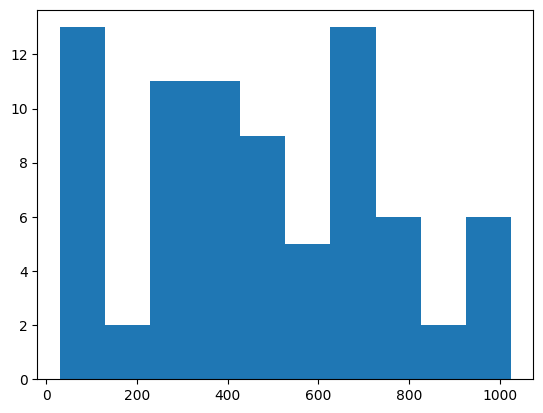

In [ ]:
# Error Yolo
plt.hist(error_gaussians_truth)
plt.show()

Max error gaussian = 72
Min error gaussian = 14


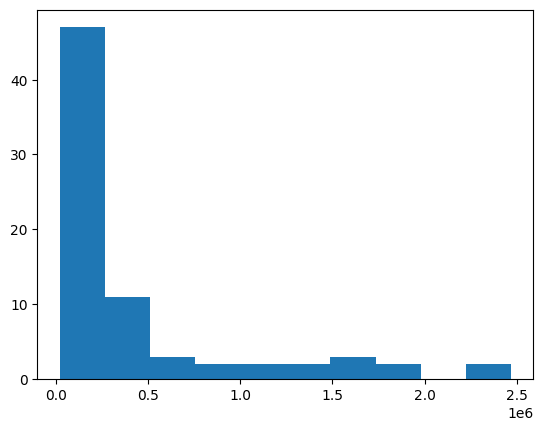

In [ ]:
# Error Yolo
plt.hist(error_gaussians_yolo)

# Gaussian min / max error
print(f'Max error gaussian = {np.argmax(np.array(error_gaussians_yolo))}')
print(f'Min error gaussian = {np.argmin(np.array(error_gaussians_yolo))}')

Max error gaussian = 70
Min error gaussian = 27


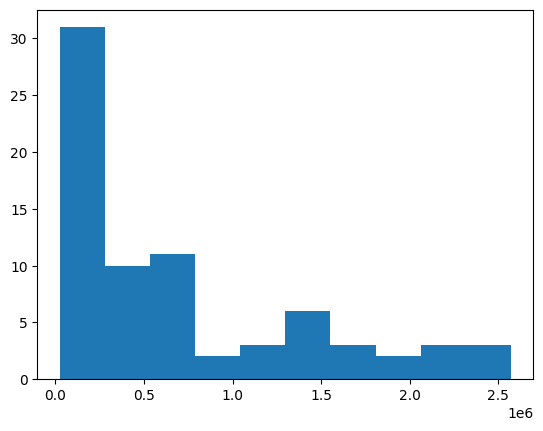

In [ ]:
# Error PX
plt.hist(error_gaussians_px)

# Gaussian min / max error
print(f'Max error gaussian = {np.argmax(np.array(error_gaussians_px))}')
print(f'Min error gaussian = {np.argmin(np.array(error_gaussians_px))}')

In [ ]:
# Important: when covariance/center changes, the region being evaluated will change, this should happend?
# I think so, as the Gaussian estimated need to be compared to the exact location in the image that it was estimated
# Is it possible in any circunstance the error be lower because of the treatd region?

#### [Study] Creating the means and covariances of the mixed models

In [ ]:
all_gaussians_ensembled = ppl_ensemble_predict_gaussians(n_image,
                                      mat_data = mat,
                                      estimation_method = ["YOLO", "YOLO_px"],
                                      peak_method = None,
                                      image_path = image_path,
                                      yolo_model = model,
                                      print_bettersecond = True)


0: 640x256 74 gaussians, 303.2ms
Speed: 2.2ms preprocess, 303.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 74 gaussians, 235.4ms
Speed: 1.9ms preprocess, 235.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[4, 5, 13, 27, 37, 68]


In [ ]:
# Generates gaussian
generated_z_ensembled_2 = sum_gaussians(image[0], # x
                                      image[1], # y
                                      all_gaussians_ensembled)

In [ ]:
# Error of the ensemble
(all_gaussians_ensembled,
generated_z_ensembled,
rmsep_ensembled,
error_gaussians_ensembled) = compute_error_per_gaussian(image,
                                  [i[0] for i in all_gaussians_ensembled],
                                  list(np.array([i[1] for i in
                                                all_gaussians_ensembled])/2),
                                  [i[2] for i in all_gaussians_ensembled])

In [ ]:
# Comparing errors - Problem is the error is lower in the context in the method
pd.DataFrame([error_gaussians_yolo, error_gaussians_px, error_gaussians_ensembled_2]).T

0             1             2
0   4.544691e+04  1.613277e+05  4.544691e+04
1   5.280561e+04  1.684567e+05  5.654977e+04
2   2.537606e+04  3.439260e+04  2.645817e+04
3   4.031923e+04  9.394205e+04  4.031752e+04
4   4.501023e+04  2.715165e+04  2.655403e+04
..           ...           ...           ...
69  1.071002e+05  1.215624e+05  1.070769e+05
70  1.545039e+06  2.570100e+06  1.545039e+06
71  1.752819e+06  2.362264e+06  2.325127e+06
72  2.468326e+06  1.868154e+06  2.579802e+06
73  2.295203e+05  4.238663e+05  2.295202e+05

[74 rows x 3 columns]

### Error evaluation ensemble Yolo and PX

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir("/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/YOLOv0_E3_detect/datasets/test/images/")
eval_images = [int(i.split('_')[1].split('.')[0]) for i in images_test] # Use the same images of the test from YOLO

In [ ]:
print(eval_images)

[533, 578, 591, 401, 513, 566, 451, 598, 518, 492, 501, 461, 473, 435, 414, 467, 491, 502, 454, 423]


In [ ]:
# Image path for error_estimation should be the folder of images
image_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/"

In [ ]:
# Iterate all images - ensembled method
results = {'Image' : [],
           'Number identified - ensembled' : [],
           'Number identifiable - ensembled' : [],
           'Percentage - ensembled' : [],
           'RMSE_cx - ensembled' : [],
           'RMSE_cy - ensembled' : [],
           'RMSE_c - ensembled' : [],
           'RMSE_sigmax - ensembled' : [],
           'RMSE_sigmay - ensembled' : [],
           'RMSE_sigma - ensembled' : [],
           'MaxE_sigmax - ensembled': [],
           'MaxE_sigmay - ensembled': [],
           'MaxE_sigma - ensembled': [],
           'RMSE_amplitude - ensembled': [],
           'RMSEPixel - ensembled': []}

for n_image in eval_images:
  eval_gaussian = ppl_error_estimation(n_image,
                                       mat,
                                       image_path = image_path,
                                       peak_method = 'laplace',
                                       yolo_model = model,
                                       estimation_method = ["YOLO", "YOLO_px"],
                                       covariance_gaussians_types = "diag",
                                       return_percentage = True)
  # Append values in the dictionary
  for key in results.keys():
      if key in eval_gaussian:
          results[key] += eval_gaussian[key]


0: 640x256 88 gaussians, 518.3ms
Speed: 2.5ms preprocess, 518.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 88 gaussians, 419.7ms
Speed: 2.0ms preprocess, 419.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.019857           0]
  [          0    0.014184]]]
covariances true [[[   0.025208           0]
  [          0    0.013856]]]



0: 640x256 85 gaussians, 411.4ms
Speed: 1.8ms preprocess, 411.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 85 gaussians, 417.2ms
Speed: 1.9ms preprocess, 417.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[    0.02841           0]
  [          0    0.015058]]]
covariances true [[[   0.028472           0]
  [          0    0.014097]]]



0: 640x256 81 gaussians, 251.3ms
Speed: 1.9ms preprocess, 251.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 81 gaussians, 232.7ms
Speed: 2.9ms preprocess, 232.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.019632           0]
  [          0    0.015083]]]
covariances true [[[   0.026581           0]
  [          0    0.014967]]]



0: 640x256 85 gaussians, 228.5ms
Speed: 2.2ms preprocess, 228.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 85 gaussians, 234.1ms
Speed: 3.7ms preprocess, 234.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020113           0]
  [          0    0.013436]]]
covariances true [[[   0.026687           0]
  [          0       0.013]]]



0: 640x256 82 gaussians, 241.3ms
Speed: 3.7ms preprocess, 241.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 82 gaussians, 244.9ms
Speed: 2.5ms preprocess, 244.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.019206           0]
  [          0     0.01549]]]
covariances true [[[   0.026525           0]
  [          0    0.015438]]]



0: 640x256 82 gaussians, 395.1ms
Speed: 2.4ms preprocess, 395.1ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 82 gaussians, 798.1ms
Speed: 5.4ms preprocess, 798.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.020567           0]
  [          0    0.013416]]]
covariances true [[[   0.026628           0]
  [          0    0.013286]]]



0: 640x256 82 gaussians, 1655.0ms
Speed: 2.0ms preprocess, 1655.0ms inference, 14.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 82 gaussians, 809.9ms
Speed: 1.9ms preprocess, 809.9ms inference, 9.3ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[    0.01932           0]
  [          0    0.015397]]]
covariances true [[[   0.027244           0]
  [          0     0.01513]]]



0: 640x256 83 gaussians, 394.8ms
Speed: 2.7ms preprocess, 394.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 83 gaussians, 375.9ms
Speed: 2.7ms preprocess, 375.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020195           0]
  [          0    0.015175]]]
covariances true [[[   0.029207           0]
  [          0    0.014956]]]



0: 640x256 84 gaussians, 382.2ms
Speed: 1.9ms preprocess, 382.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 84 gaussians, 396.3ms
Speed: 2.1ms preprocess, 396.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.018917           0]
  [          0    0.015168]]]
covariances true [[[   0.025066           0]
  [          0    0.015104]]]



0: 640x256 89 gaussians, 234.8ms
Speed: 1.8ms preprocess, 234.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 89 gaussians, 235.8ms
Speed: 2.0ms preprocess, 235.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.019516           0]
  [          0    0.014899]]]
covariances true [[[   0.025824           0]
  [          0    0.014366]]]



0: 640x256 82 gaussians, 247.2ms
Speed: 4.8ms preprocess, 247.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 82 gaussians, 237.8ms
Speed: 1.8ms preprocess, 237.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[    0.02036           0]
  [          0      0.0152]]]
covariances true [[[   0.029185           0]
  [          0    0.015094]]]



0: 640x256 83 gaussians, 406.4ms
Speed: 1.9ms preprocess, 406.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 83 gaussians, 403.4ms
Speed: 1.9ms preprocess, 403.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.019429           0]
  [          0    0.015199]]]
covariances true [[[   0.027597           0]
  [          0    0.015262]]]



0: 640x256 83 gaussians, 410.4ms
Speed: 1.9ms preprocess, 410.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 83 gaussians, 232.4ms
Speed: 1.6ms preprocess, 232.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.029196           0]
  [          0    0.014208]]]
covariances true [[[   0.029643           0]
  [          0    0.013242]]]



0: 640x256 83 gaussians, 250.4ms
Speed: 5.5ms preprocess, 250.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 83 gaussians, 231.6ms
Speed: 2.8ms preprocess, 231.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.020739           0]
  [          0    0.013973]]]
covariances true [[[    0.02865           0]
  [          0    0.013551]]]



0: 640x256 83 gaussians, 238.5ms
Speed: 2.1ms preprocess, 238.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 83 gaussians, 236.8ms
Speed: 2.0ms preprocess, 236.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.019564           0]
  [          0    0.014294]]]
covariances true [[[   0.028288           0]
  [          0    0.014184]]]



0: 640x256 84 gaussians, 235.9ms
Speed: 1.9ms preprocess, 235.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 84 gaussians, 235.7ms
Speed: 1.9ms preprocess, 235.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.020036           0]
  [          0    0.013834]]]
covariances true [[[    0.02559           0]
  [          0    0.013789]]]



0: 640x256 84 gaussians, 240.6ms
Speed: 2.2ms preprocess, 240.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 84 gaussians, 226.2ms
Speed: 2.5ms preprocess, 226.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020398           0]
  [          0    0.015234]]]
covariances true [[[   0.027806           0]
  [          0    0.014778]]]



0: 640x256 88 gaussians, 229.5ms
Speed: 2.0ms preprocess, 229.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 88 gaussians, 232.5ms
Speed: 2.0ms preprocess, 232.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.019045           0]
  [          0    0.014896]]]
covariances true [[[   0.025469           0]
  [          0    0.013943]]]



0: 640x256 83 gaussians, 230.0ms
Speed: 2.0ms preprocess, 230.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 83 gaussians, 232.3ms
Speed: 2.1ms preprocess, 232.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020512           0]
  [          0    0.013606]]]
covariances true [[[   0.025673           0]
  [          0    0.013175]]]



0: 640x256 85 gaussians, 1043.7ms
Speed: 1.8ms preprocess, 1043.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 85 gaussians, 507.5ms
Speed: 1.9ms preprocess, 507.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020668           0]
  [          0    0.013241]]]
covariances true [[[   0.026166           0]
  [          0    0.012974]]]


In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[['mean', 'std', 'max']].T

mean        std         max
Image                                493.10      58.18      598.00
Number identified - ensembled         83.95       2.19       89.00
Number identifiable - ensembled       79.00       0.00       79.00
Percentage - ensembled               106.26       2.77      112.66
RMSE_cx - ensembled                   10.66       0.24       11.19
RMSE_cy - ensembled                    0.21       0.03        0.24
RMSE_c - ensembled                    10.66       0.24       11.19
RMSE_sigmax - ensembled               14.08       1.17       16.94
RMSE_sigmay - ensembled                3.58       0.21        4.13
RMSE_sigma - ensembled                14.53       1.17       17.43
MaxE_sigmax - ensembled               73.45       5.67       77.83
MaxE_sigmay - ensembled               74.13       1.92       77.29
MaxE_sigma - ensembled               104.44       4.32      107.93
RMSE_amplitude - ensembled            98.39       2.21      102.66
RMSEPixel - ensembled            5663977.13  139719.84  6110824.02

In [ ]:
# Results
pd.DataFrame.from_dict(results).round(2).sort_values('Image')

Image  Number identified - ensembled  Number identifiable - ensembled  \
3     401                             85                               79   
14    414                             83                               79   
19    423                             85                               79   
13    435                             83                               79   
6     451                             82                               79   
18    454                             83                               79   
11    461                             83                               79   
15    467                             84                               79   
12    473                             83                               79   
16    491                             84                               79   
9     492                             89                               79   
10    501                             82                               79   
17    502                             88                               79   
4     513                             82                               79   
8     518                             84                               79   
0     533                             88                               79   
5     566                             82                               79   
1     578                             85                               79   
2     591                             81                               79   
7     598                             83                               79   

    Percentage - ensembled  RMSE_cx - ensembled  RMSE_cy - ensembled  \
3                   107.59                10.61                 0.21   
14                  105.06                11.19                 0.19   
19                  107.59                10.67                 0.23   
13                  105.06                10.95                 0.24   
6                   103.80                10.71                 0.23   
18                  105.06                10.75                 0.22   
11                  105.06                10.60                 0.21   
15                  106.33                10.45                 0.22   
12                  105.06                10.81                 0.19   
16                  106.33                10.97                 0.21   
9                   112.66                10.52                 0.18   
10                  103.80                10.77                 0.24   
17                  111.39                10.23                 0.16   
4                   103.80                10.84                 0.16   
8                   106.33                10.19                 0.21   
0                   111.39                10.56                 0.20   
5                   103.80                10.58                 0.20   
1                   107.59                10.71                 0.24   
2                   102.53                10.37                 0.18   
7                   105.06                10.65                 0.19   

    RMSE_c - ensembled  RMSE_sigmax - ensembled  RMSE_sigmay - ensembled  \
3                10.61                    15.13                     3.80   
14               11.19                    14.19                     3.73   
19               10.67                    14.43                     3.74   
13               10.95                    13.55                     3.52   
6                10.71                    13.34                     3.48   
18               10.75                    13.38                     3.42   
11               10.60                    13.71                     3.29   
15               10.45                    14.09                     3.57   
12               10.82                    13.41                     3.59   
16               10.97                    14.20                     3.72   
9                10.52               

In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(snapshot_folder_path = snapshot_folder_path,
                 error_dataframe = pd.DataFrame.from_dict(results).sort_values('Image'),
                 annotation = f"""Amplitudes estimated using the center directly\n
                 image_path = {image_path}\n
                 id_estimation_method = {model.__dict__['ckpt_path']}\n
                 id_images evaluated: {eval_images}""",
                 name = "E3YOLOENSEBPX")

### Error evaluation ensemble Yolo and PX - infer

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir("/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/YOLOv0_E3_detect/datasets/test/images/")
eval_images = [int(i.split('_')[1].split('.')[0]) for i in images_test] # Use the same images of the test from YOLO

In [ ]:
print(eval_images)

[533, 578, 591, 401, 513, 566, 451, 598, 518, 492, 501, 461, 473, 435, 414, 467, 491, 502, 454, 423]


In [ ]:
# Image path for error_estimation should be the folder of images
image_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/"

In [ ]:
# Iterate all images - ensembled method
results = {'Image' : [],
           'Number identified - ensembled' : [],
           'Number identifiable - ensembled' : [],
           'Percentage - ensembled' : [],
           'RMSE_cx - ensembled' : [],
           'RMSE_cy - ensembled' : [],
           'RMSE_c - ensembled' : [],
           'RMSE_sigmax - ensembled' : [],
           'RMSE_sigmay - ensembled' : [],
           'RMSE_sigma - ensembled' : [],
           'MaxE_sigmax - ensembled': [],
           'MaxE_sigmay - ensembled': [],
           'MaxE_sigma - ensembled': [],
           'RMSE_amplitude - ensembled': [],
           'RMSEPixel - ensembled': []}

for n_image in eval_images:
  eval_gaussian = ppl_error_estimation(n_image,
                                       mat,
                                       image_path = image_path,
                                       peak_method = 'laplace',
                                       yolo_model = model,
                                       estimation_method = ["YOLO", "YOLO_px_infer"],
                                       covariance_gaussians_types = "diag",
                                       return_percentage = True)
  # Append values in the dictionary
  for key in results.keys():
      if key in eval_gaussian:
          results[key] += eval_gaussian[key]


0: 640x256 88 gaussians, 593.1ms
Speed: 2.0ms preprocess, 593.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 88 gaussians, 1476.5ms
Speed: 2.0ms preprocess, 1476.5ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.019857           0]
  [          0    0.014184]]]
covariances true [[[   0.025208           0]
  [          0    0.013856]]]



0: 640x256 85 gaussians, 450.4ms
Speed: 2.0ms preprocess, 450.4ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 85 gaussians, 417.8ms
Speed: 2.1ms preprocess, 417.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[    0.02841           0]
  [          0    0.015058]]]
covariances true [[[   0.028472           0]
  [          0    0.014097]]]



0: 640x256 81 gaussians, 398.4ms
Speed: 2.5ms preprocess, 398.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 81 gaussians, 267.7ms
Speed: 2.5ms preprocess, 267.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.019632           0]
  [          0    0.015083]]]
covariances true [[[   0.026581           0]
  [          0    0.014967]]]



0: 640x256 85 gaussians, 275.8ms
Speed: 1.9ms preprocess, 275.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 85 gaussians, 258.3ms
Speed: 3.2ms preprocess, 258.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020113           0]
  [          0    0.013436]]]
covariances true [[[   0.026687           0]
  [          0       0.013]]]



0: 640x256 82 gaussians, 411.1ms
Speed: 4.0ms preprocess, 411.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 82 gaussians, 428.9ms
Speed: 1.9ms preprocess, 428.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.019206           0]
  [          0     0.01549]]]
covariances true [[[   0.026525           0]
  [          0    0.015438]]]



0: 640x256 82 gaussians, 828.9ms
Speed: 2.8ms preprocess, 828.9ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 82 gaussians, 630.1ms
Speed: 2.0ms preprocess, 630.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.020567           0]
  [          0    0.013416]]]
covariances true [[[   0.026628           0]
  [          0    0.013286]]]



0: 640x256 82 gaussians, 237.2ms
Speed: 3.2ms preprocess, 237.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 82 gaussians, 240.4ms
Speed: 1.5ms preprocess, 240.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[    0.01932           0]
  [          0    0.015397]]]
covariances true [[[   0.027244           0]
  [          0     0.01513]]]



0: 640x256 83 gaussians, 232.9ms
Speed: 2.0ms preprocess, 232.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 83 gaussians, 247.7ms
Speed: 1.9ms preprocess, 247.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020195           0]
  [          0    0.015175]]]
covariances true [[[   0.029207           0]
  [          0    0.014956]]]



0: 640x256 84 gaussians, 241.8ms
Speed: 2.3ms preprocess, 241.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 84 gaussians, 231.6ms
Speed: 2.2ms preprocess, 231.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.018917           0]
  [          0    0.015168]]]
covariances true [[[   0.025066           0]
  [          0    0.015104]]]



0: 640x256 89 gaussians, 226.7ms
Speed: 3.2ms preprocess, 226.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 89 gaussians, 234.3ms
Speed: 2.2ms preprocess, 234.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.019516           0]
  [          0    0.014899]]]
covariances true [[[   0.025824           0]
  [          0    0.014366]]]



0: 640x256 82 gaussians, 240.3ms
Speed: 2.5ms preprocess, 240.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 82 gaussians, 240.3ms
Speed: 2.5ms preprocess, 240.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[    0.02036           0]
  [          0      0.0152]]]
covariances true [[[   0.029185           0]
  [          0    0.015094]]]



0: 640x256 83 gaussians, 233.3ms
Speed: 1.5ms preprocess, 233.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 83 gaussians, 327.9ms
Speed: 1.7ms preprocess, 327.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.019429           0]
  [          0    0.015199]]]
covariances true [[[   0.027597           0]
  [          0    0.015262]]]



0: 640x256 83 gaussians, 403.7ms
Speed: 1.9ms preprocess, 403.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 83 gaussians, 404.6ms
Speed: 2.0ms preprocess, 404.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.029196           0]
  [          0    0.014208]]]
covariances true [[[   0.029643           0]
  [          0    0.013242]]]



0: 640x256 83 gaussians, 401.0ms
Speed: 1.9ms preprocess, 401.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 83 gaussians, 235.2ms
Speed: 2.1ms preprocess, 235.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.020739           0]
  [          0    0.013973]]]
covariances true [[[    0.02865           0]
  [          0    0.013551]]]



0: 640x256 83 gaussians, 235.5ms
Speed: 2.4ms preprocess, 235.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 83 gaussians, 239.1ms
Speed: 1.8ms preprocess, 239.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.019564           0]
  [          0    0.014294]]]
covariances true [[[   0.028288           0]
  [          0    0.014184]]]



0: 640x256 84 gaussians, 234.0ms
Speed: 2.0ms preprocess, 234.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 84 gaussians, 240.5ms
Speed: 1.9ms preprocess, 240.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:87: RuntimeWarning: invalid value encountered in double_scalars
  covariance[0][0] = covariance[0][0]/(logical_up[0][0] + logical_down[0][0])


covariances [[[   0.020036           0]
  [          0    0.013834]]]
covariances true [[[    0.02559           0]
  [          0    0.013789]]]



0: 640x256 84 gaussians, 232.7ms
Speed: 1.9ms preprocess, 232.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 84 gaussians, 243.6ms
Speed: 2.0ms preprocess, 243.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020398           0]
  [          0    0.015234]]]
covariances true [[[   0.027806           0]
  [          0    0.014778]]]



0: 640x256 88 gaussians, 235.5ms
Speed: 3.2ms preprocess, 235.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 88 gaussians, 236.5ms
Speed: 5.1ms preprocess, 236.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.019045           0]
  [          0    0.014896]]]
covariances true [[[   0.025469           0]
  [          0    0.013943]]]



0: 640x256 83 gaussians, 246.8ms
Speed: 2.4ms preprocess, 246.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 83 gaussians, 241.0ms
Speed: 2.0ms preprocess, 241.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020512           0]
  [          0    0.013606]]]
covariances true [[[   0.025673           0]
  [          0    0.013175]]]



0: 640x256 85 gaussians, 243.9ms
Speed: 2.2ms preprocess, 243.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 85 gaussians, 235.2ms
Speed: 2.1ms preprocess, 235.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020668           0]
  [          0    0.013241]]]
covariances true [[[   0.026166           0]
  [          0    0.012974]]]


In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[['mean', 'std', 'max']].T

mean        std         max
Image                                493.10      58.18      598.00
Number identified - ensembled         83.95       2.19       89.00
Number identifiable - ensembled       79.00       0.00       79.00
Percentage - ensembled               106.26       2.77      112.66
RMSE_cx - ensembled                   10.66       0.24       11.19
RMSE_cy - ensembled                    0.21       0.03        0.24
RMSE_c - ensembled                    10.66       0.24       11.19
RMSE_sigmax - ensembled               14.08       1.17       16.94
RMSE_sigmay - ensembled                3.58       0.21        4.13
RMSE_sigma - ensembled                14.53       1.17       17.43
MaxE_sigmax - ensembled               73.45       5.67       77.83
MaxE_sigmay - ensembled               74.13       1.92       77.29
MaxE_sigma - ensembled               104.44       4.32      107.93
RMSE_amplitude - ensembled            98.39       2.21      102.66
RMSEPixel - ensembled            5663977.13  139719.84  6110824.02

In [ ]:
# Results
pd.DataFrame.from_dict(results).round(2).sort_values('Image')

Image  Number identified - ensembled  Number identifiable - ensembled  \
3     401                             85                               79   
14    414                             83                               79   
19    423                             85                               79   
13    435                             83                               79   
6     451                             82                               79   
18    454                             83                               79   
11    461                             83                               79   
15    467                             84                               79   
12    473                             83                               79   
16    491                             84                               79   
9     492                             89                               79   
10    501                             82                               79   
17    502                             88                               79   
4     513                             82                               79   
8     518                             84                               79   
0     533                             88                               79   
5     566                             82                               79   
1     578                             85                               79   
2     591                             81                               79   
7     598                             83                               79   

    Percentage - ensembled  RMSE_cx - ensembled  RMSE_cy - ensembled  \
3                   107.59                10.61                 0.21   
14                  105.06                11.19                 0.19   
19                  107.59                10.67                 0.23   
13                  105.06                10.95                 0.24   
6                   103.80                10.71                 0.23   
18                  105.06                10.75                 0.22   
11                  105.06                10.60                 0.21   
15                  106.33                10.45                 0.22   
12                  105.06                10.81                 0.19   
16                  106.33                10.97                 0.21   
9                   112.66                10.52                 0.18   
10                  103.80                10.77                 0.24   
17                  111.39                10.23                 0.16   
4                   103.80                10.84                 0.16   
8                   106.33                10.19                 0.21   
0                   111.39                10.56                 0.20   
5                   103.80                10.58                 0.20   
1                   107.59                10.71                 0.24   
2                   102.53                10.37                 0.18   
7                   105.06                10.65                 0.19   

    RMSE_c - ensembled  RMSE_sigmax - ensembled  RMSE_sigmay - ensembled  \
3                10.61                    15.13                     3.80   
14               11.19                    14.19                     3.73   
19               10.67                    14.43                     3.74   
13               10.95                    13.55                     3.52   
6                10.71                    13.34                     3.48   
18               10.75                    13.38                     3.42   
11               10.60                    13.71                     3.29   
15               10.45                    14.09                     3.57   
12               10.82                    13.41                     3.59   
16               10.97                    14.20                     3.72   
9                10.52               

In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(snapshot_folder_path = snapshot_folder_path,
                 error_dataframe = pd.DataFrame.from_dict(results).sort_values('Image'),
                 annotation = f"""Amplitudes estimated using the center directly\n
                 image_path = {image_path}\n
                 id_estimation_method = {model.__dict__['ckpt_path']}\n
                 id_images evaluated: {eval_images}""",
                 name = "E3YOLOENSEBPXINFER")

## Whole image generate - plotting ensembled

In [ ]:
# Load data
n_image = 409

# Image - z intensities
image = [x,
         y,
         mat['F_data'][:,:, n_image]]

image_ranges = [(0, 0.143),
                (0, 0.377)]
image_size = [143, 377]

# Parameters extraction
(amplitude,
 xs,
 ys,
 dispersion_x,
 dispersion_y) = parameters_extract(mat['Fit_flux'], n_image)

In [ ]:
# Predict Yolo
labels_type = "Labelsv0_detect"
task = "detect"
model_name = "YOLOv0_E3_detect"
date_train = "2023-08-21_10-25-30"

image_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/gaussian_{n_image}.png"
label_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/{labels_type}/gaussian_{n_image}.txt"

# Load our custom model
model = YOLO(f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{model_name}/runs/{date_train}/{task}/train/weights/best.pt")

(means,
 covariances,
 amplitudes_yolo) = ppl_yolo_predict_gaussians(mat,
                                               n_image,
                                               model,
                                               image_path,
                                               image_ranges = image_ranges,
                                               image_size = image_size)


0: 640x256 84 gaussians, 1032.2ms
Speed: 3.7ms preprocess, 1032.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


In [ ]:
# Yolo and refining center and dispersion (Max Amp. and PX)
(converted_new_means_infer,
new_covariances_infer,
amplitudes_px_infer,
new_means_infer,
new_covariances_up_infer,
new_covariances_down_infer) = ppl_yolo_px_predict_gaussians(mat,
                                                            n_image,
                                                            model,
                                                            image_path,
                                                            px_step_size = 3,
                                                            infer_overlapping = True)


0: 640x256 84 gaussians, 230.4ms
Speed: 1.9ms preprocess, 230.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


In [ ]:
# Sanity check truth
means_truth = list(zip(xs, ys))
covariances_truth = [np.array([[(wx/(np.sqrt(2)))**2, 0],
                               [0, (wy/(np.sqrt(2)))**2]]) for
                     wx, wy in zip(dispersion_x, dispersion_y)]
amplitudes_truth = amplitude
(all_gaussians_truth,
 generated_z_truth,
 rmsep_truth,
 error_gaussians_truth) = compute_error_per_gaussian(image,
                                                     means_truth,
                                                     covariances_truth,
                                                     amplitudes_truth)

Gaussian 31 center is out of bounds


In [ ]:
# Compute YOLO
(all_gaussians_yolo,
 generated_z_yolo,
 rmsep_yolo,
 error_gaussians_yolo) = compute_error_per_gaussian(image,
                                                    means,
                                                    list(covariances/2),
                                                    amplitudes_yolo)

In [ ]:
# Compute YOLO + PX
(all_gaussians_px,
 generated_z_px,
 rmsep_px,
 error_gaussians_px) = compute_error_per_gaussian(image,
                                                  converted_new_means_infer,
                                                  list(new_covariances_infer/2),
                                                  amplitudes_px_infer)

In [ ]:
all_gaussians_ensembled = ppl_ensemble_predict_gaussians(n_image,
                                      mat_data = mat,
                                      estimation_method = ["YOLO", "YOLO_px_infer"],
                                      peak_method = None,
                                      image_path = image_path,
                                      yolo_model = model,
                                      print_bettersecond = True)


0: 640x256 84 gaussians, 233.4ms
Speed: 2.3ms preprocess, 233.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 84 gaussians, 238.4ms
Speed: 2.9ms preprocess, 238.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


[]


In [ ]:
# Error of the ensemble
(all_gaussians_ensembled,
generated_z_ensembled,
rmsep_ensembled,
error_gaussians_ensembled) = compute_error_per_gaussian(image,
                                  [i[0] for i in all_gaussians_ensembled],
                                  list(np.array([i[1] for i in
                                                all_gaussians_ensembled])/2),
                                  [i[2] for i in all_gaussians_ensembled])

In [ ]:
# Create subplots
plt.ioff()
fig, ax = plt.subplots(1, 4, figsize = (15, 10))
all_texts = []

In [ ]:
# Original image
plot_grayscale(x,
               y,
               image[2],
               colorbar = False,
               ax = ax[0])

Text(0.5, 0, 'x - Truth')

In [ ]:
# Yolo Image
plot_grayscale(x,
               y,
               generated_z_yolo,
               colorbar = False,
               ax = ax[2])
ax[2].set_xlabel("x - YOLO")

Text(0.5, 0, 'x - YOLO')

In [ ]:
# PX image
plot_grayscale(x,
               y,
               generated_z_px,
               colorbar = False,
               ax = ax[3])
ax[3].set_xlabel("x - PX Infer")

Text(0.5, 0, 'x - PX Infer')

In [ ]:
# PX image
plot_grayscale(x,
               y,
               generated_z_ensembled,
               colorbar = False,
               ax = ax[1])
ax[1].set_xlabel("x - Ensembled")

Text(0.5, 0, 'x - Ensembled')

In [ ]:
# Distance of axis
fig.subplots_adjust(wspace= 0.1)

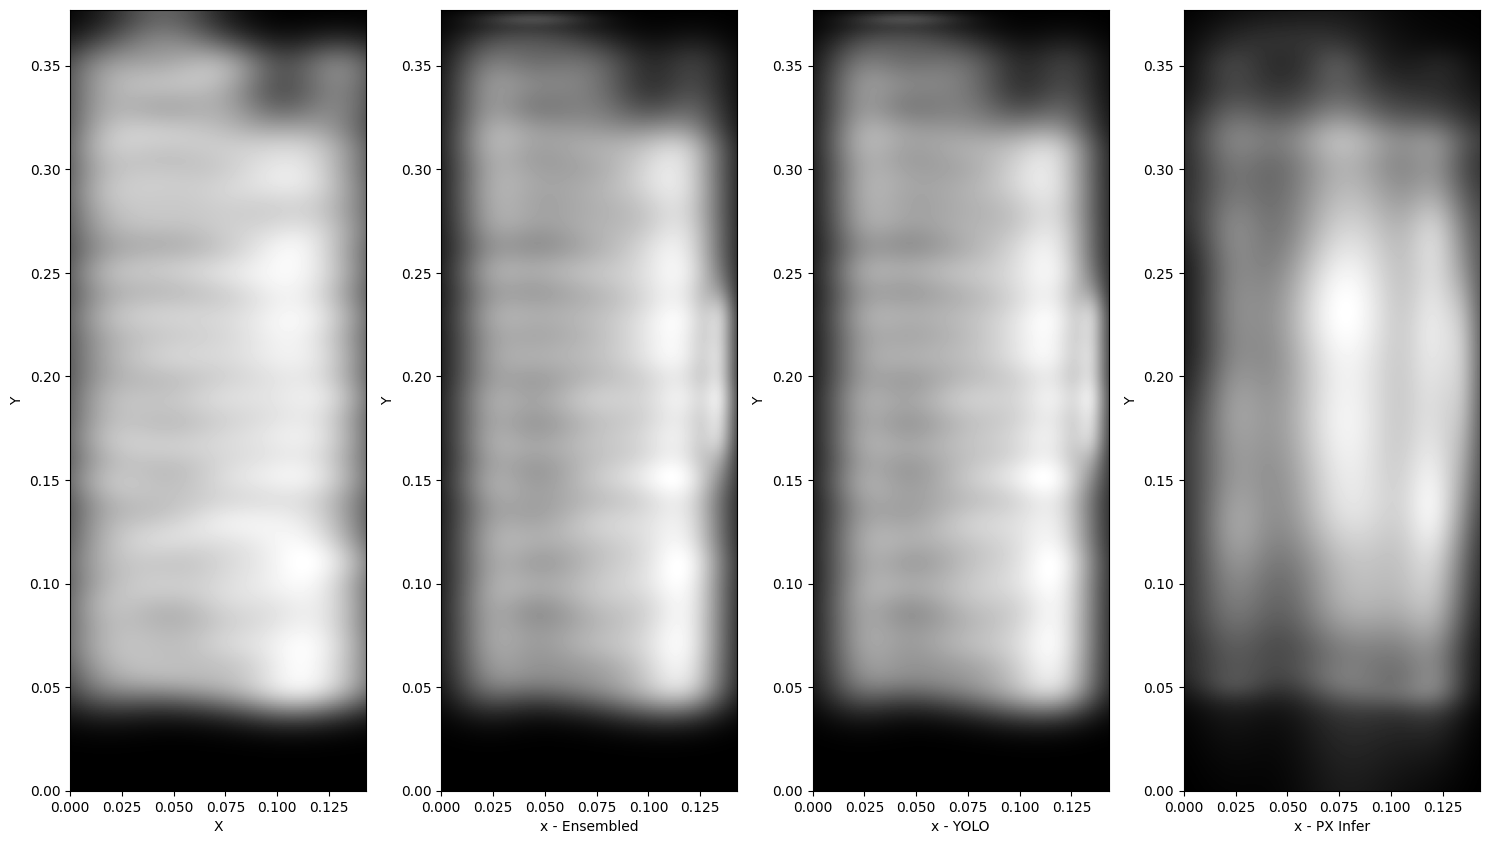

In [ ]:
plt.ion()
plt.tight_layout()
plt.show()

###### Subregion by Gaussian plotting

In [ ]:
n_gaussian = 30
center = all_gaussians[n_gaussian][0]
covariance = all_gaussians[n_gaussian][1]
# Extract region - reconstructed with true one
sub_region = extract_region(generated_z,
                            center,
                            covariance,
                            return_cropped = False)
# Extract region - true one
sub_region_truth = extract_region(image[2],
                                  center,
                                  covariance,
                                  return_cropped = False)

In [ ]:
# Create subplots
plt.ioff()
fig, ax = plt.subplots(1, 2, figsize = (15, 10))
all_texts = []

In [ ]:
# Original image
plot_grayscale(x,
               y,
               sub_region,
               colorbar = False,
               ax = ax[0])

In [ ]:
# Original image
plot_grayscale(x,
               y,
               sub_region_truth,
               colorbar = False,
               ax = ax[1])

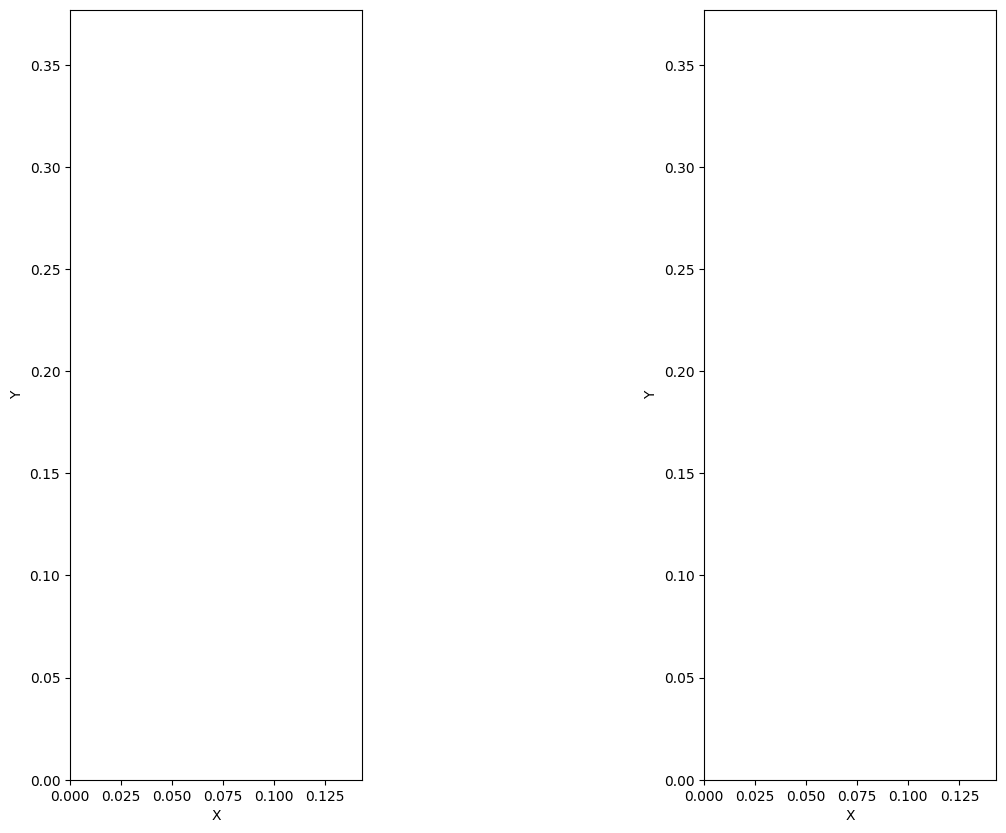

In [ ]:
plt.ion()
plt.show()

###### Cropped region by gaussian plotting

In [ ]:
# Matches Gaussians
row_ind, col_ind = match_gaussians([gaussian[0] for gaussian in all_gaussians_yolo],
                                   list(zip(xs, ys)))

In [ ]:
n_gaussian = 72
n_gaussian_truth = col_ind[np.where(row_ind == n_gaussian)[0]][0]

# YOLO
center = all_gaussians_yolo[n_gaussian][0]
covariance = all_gaussians_yolo[n_gaussian][1]
# Extract region - reconstructed with true one
(sub_region,
 cropped_region,
 _) = extract_region(generated_z_yolo,
                     center,
                     covariance,
                     return_cropped = True)

# Extract region - true one
(sub_region_truth,
 cropped_region_truth,
 region_limits) = extract_region(image[2],
                                 center,
                                 covariance,
                                 return_cropped = True)
# PX
center = all_gaussians_px[n_gaussian][0]
covariance = all_gaussians_px[n_gaussian][1]
# Extract region - reconstructed with true one
(sub_region_px,
 cropped_region_px,
 _) = extract_region(generated_z_px,
                     center,
                     covariance,
                     return_cropped = True)

In [ ]:
# Create subplots
plt.ioff()
fig, ax = plt.subplots(2, 2, figsize = (15, 10))
all_texts = []

In [ ]:
# Original image
plot_grayscale(x[region_limits[0][0] : region_limits[0][1],
                 region_limits[1][0] : region_limits[1][1]],
               y[region_limits[0][0] : region_limits[0][1],
                 region_limits[1][0] : region_limits[1][1]],
               cropped_region_truth,
               colorbar = True,
               ax = ax[0, 0])
ax[0, 0].set_title('Ground truth')

# Plot updated centers
ax[0, 0].scatter(xs[n_gaussian_truth],
              ys[n_gaussian_truth],
              s = 3, c = 'green')

In [ ]:
# YOLO image
plot_grayscale(x[region_limits[0][0] : region_limits[0][1],
                 region_limits[1][0] : region_limits[1][1]],
               y[region_limits[0][0] : region_limits[0][1],
                 region_limits[1][0] : region_limits[1][1]],
               cropped_region,
               colorbar = True,
               ax = ax[0, 1])
ax[0, 1].set_title('Yolo prediction')

# Plot updated centers
ax[0, 1].scatter(np.array(means)[:, 0][n_gaussian],
              np.array(means)[:, 1][n_gaussian],
              s = 3, c = 'red')

In [ ]:
# Original image
plot_grayscale(x[region_limits[0][0] : region_limits[0][1],
                 region_limits[1][0] : region_limits[1][1]],
               y[region_limits[0][0] : region_limits[0][1],
                 region_limits[1][0] : region_limits[1][1]],
               cropped_region,
               colorbar = True,
               ax = ax[1, 0])
ax[1, 0].set_title('PX prediction')

# Plot updated centers
ax[1, 0].scatter(np.array(means)[:, 0][n_gaussian],
              np.array(means)[:, 1][n_gaussian],
              s = 3, c = 'red')

In [ ]:
ax[1, 1].axis('off')

(0.0, 1.0, 0.0, 1.0)

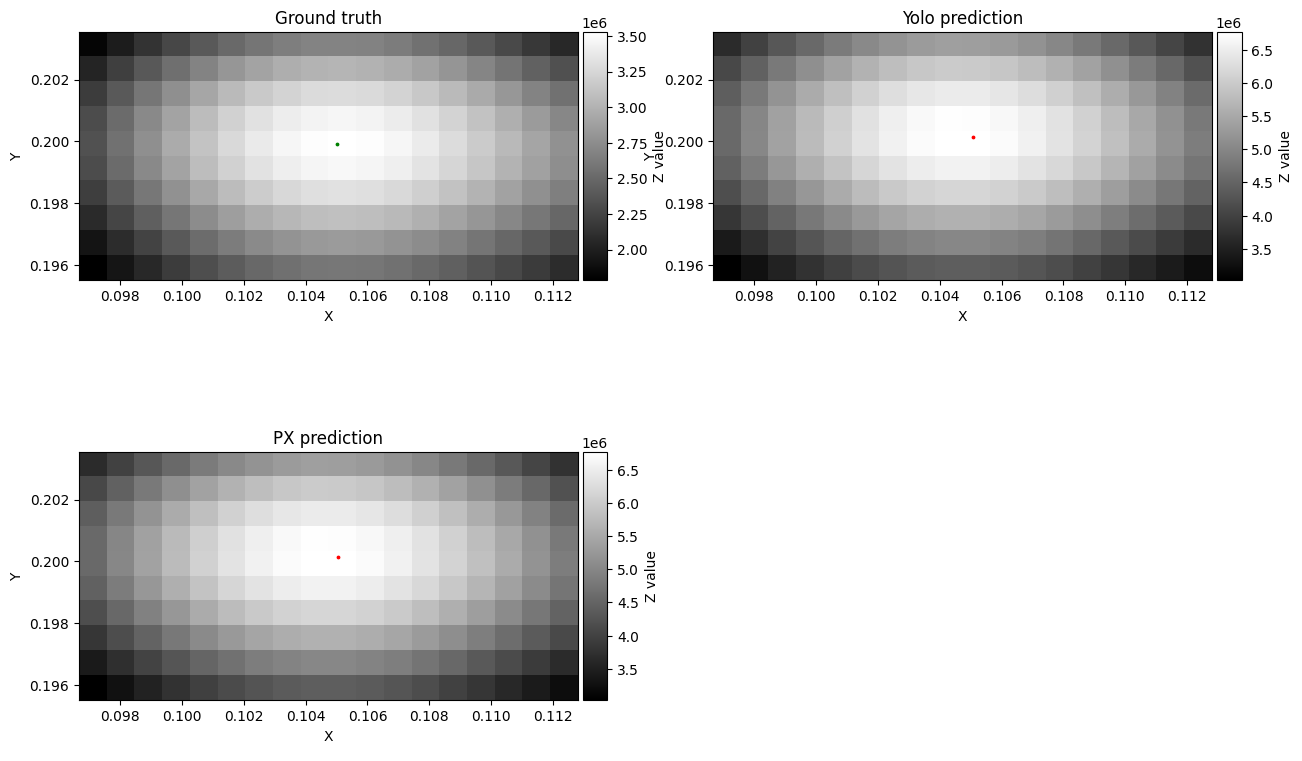

In [ ]:
plt.ion()
plt.show()

#### Evaluate new centers gaussian - NOT Done

In [ ]:
# Create subplots
plt.ioff()
fig, ax = plt.subplots(1, figsize = (25, 20))
all_texts = []

In [ ]:
# Original image
plot_grayscale(x, y, mat['F_data'][:,:, n_image],
               colorbar = False,
               ax = ax)

#### Evaluate new centers yolo

In [ ]:
# Create subplots
plt.ioff()
fig, ax = plt.subplots(1, figsize = (25, 20))
all_texts = []

In [ ]:
# Original image
plot_grayscale(x, y, mat['F_data'][:,:, n_image],
               colorbar = False,
               ax = ax)

In [ ]:
# YOLO Check covariance and center are ok
image_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/gaussian_{n_image}.png"
task = "detect"
model_name = "YOLOv0_detect"

image_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/gaussian_{n_image}.png"

# Load our custom model
model = YOLO(f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{model_name}/runs/2023-07-26_18-50-24/{task}/train/weights/best.pt")

# Predict
(means,
 covariances,
 amplitudes) = ppl_yolo_predict_gaussians(mat,
                                          n_image,
                                          model,
                                          image_path,
                                          image_ranges = image_ranges,
                                          image_size = image_size)

# Plot box and center
all_texts = all_texts + plot_box_labels(image,
                                  [(x, y) for x, y in means],
                                  [(wx, wy) for wx, wy in
                                   zip(np.sqrt(covariances[:, 0, 0]),
                                       np.sqrt(covariances[:, 1, 1]))],
                                  ax = ax,
                                  center_color = 'b',
                                  annotate_gaussians = True,
                                  text_color = 'blue')


0: 640x256 74 gaussians, 307.3ms
Speed: 1.1ms preprocess, 307.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)


In [ ]:
# n_gaussian_tocheck = 43
# ax.scatter(np.array(means)[n_gaussian_tocheck, 0], np.array(means)[n_gaussian_tocheck, 1], s = 3, c = 'red')

In [ ]:
# Plot box and center
all_texts = all_texts + plot_box_labels(image,
                                        list(zip(xs, ys)),
                                        list(zip(dispersion_x, dispersion_y)),
                                        ax = ax,
                                        box_edge_color = 'g',
                                        center_color = 'g',
                                        annotate_gaussians = True)

In [ ]:
# Plot updated centers
ax.scatter(np.array(converted_new_means)[:, 0],
           np.array(converted_new_means)[:, 1],
           s = 3, c = 'red')

In [ ]:
# Use adjust_text to avoid overlapping for all texts
adjust_text(all_texts)

11

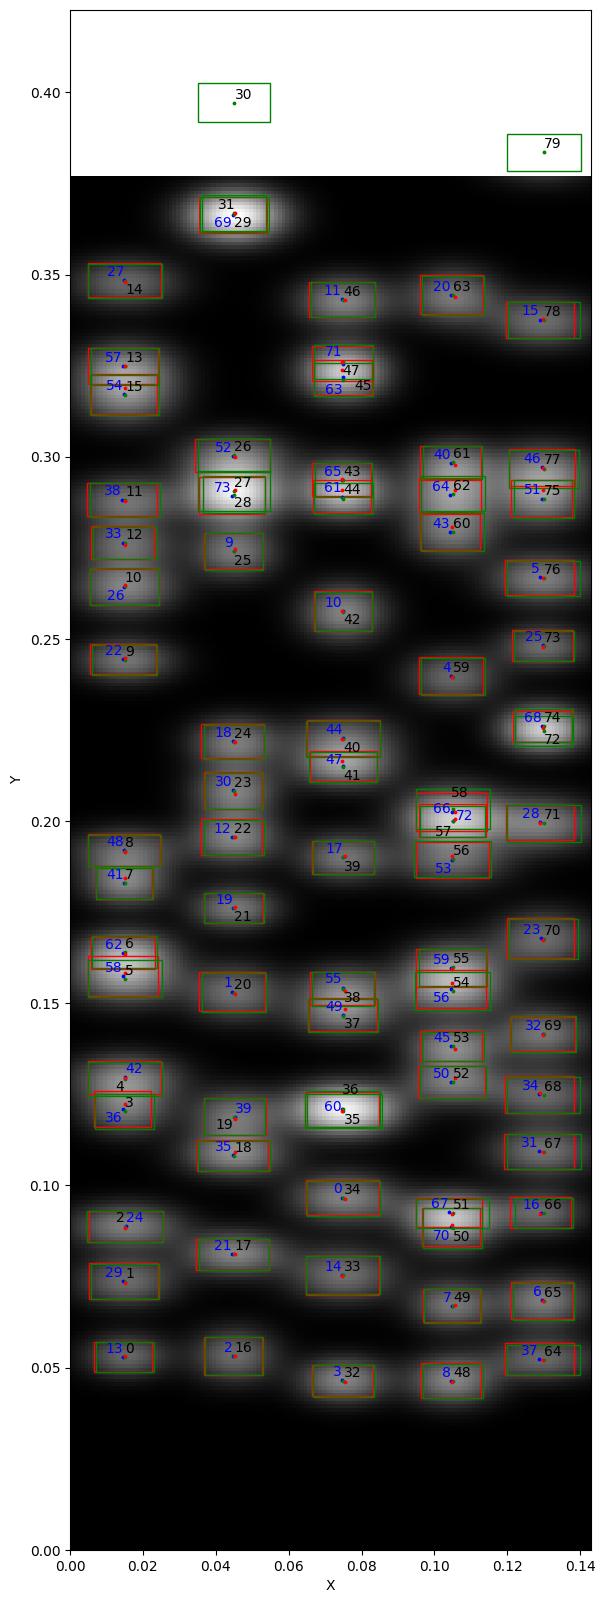

In [ ]:
plt.ion()
plt.show()

## [Estimation] Untangling Gaussians
- When Gaussians sum up in the image, it is not even possible to perfecly identify the centers as one interferes with the other

##### 3D evaluation of region

In [ ]:
# Plot region
n_gaussian_truth = 57
n_gaussian_yolo = 72 # The relation gaussian yolo and true comes from graph

# Center of the image to crop
x_center, y_center = (xs[n_gaussian_truth],
                      ys[n_gaussian_truth])
# Width and Height of the image to crop
width, length = (6 * dispersion_x[n_gaussian_truth],
                 6 * dispersion_y[n_gaussian_truth])

# Plot points
extra_pts = [{'x': xs[n_gaussian_truth],
              'y': ys[n_gaussian_truth], 'color': 'green'},
             {'x': means[n_gaussian_yolo][0],
              'y': means[n_gaussian_yolo][1], 'color': 'blue'},
             {'x': converted_new_means[n_gaussian_yolo][0],
              'y': converted_new_means[n_gaussian_yolo][1], 'color': 'black'}]

fig = plot_2d_region(image,
               x_center,
               y_center,
               width,
               length,
               colorscale = 'Reds',
               show_points = True,
               annotate = True,
               extra_points = extra_pts)

fig.show()

In [ ]:
# Plot region
n_gaussian = 57
# Center of the image to crop
x_center, y_center = xs[n_gaussian], ys[n_gaussian]
# Width and Height of the image to crop
width, length = (6 * dispersion_x[n_gaussian],
                 6 * dispersion_y[n_gaussian])
fig = plot_3d_region(image,
                     x_center,
                     y_center,
                     width,
                     length,
                     show_surface = False,
                     colorscale = None,
                     show_points = True,
                     annotate = True)

fig.show()

In [ ]:
# Plot region
n_gaussian = 57
# Center of the image to crop
x_center, y_center = xs[n_gaussian], ys[n_gaussian]
# Width and Height of the image to crop
width, length = (6 * dispersion_x[n_gaussian],
                 6 * dispersion_y[n_gaussian])
fig = plot_3d_region(image,
                     x_center,
                     y_center,
                     width,
                     length,
                     show_surface = True,
                     colorscale = None,
                     show_points = False,
                     annotate = True)

fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# First example of convoluted Gaussians
# Plot region
n_gaussian_truth = 57
n_gaussian_yolo = 72 # The relation gaussian yolo and true comes from graph

# Gaussians summed to the 57
n_gaussians_connected = [56, 58, 71]

# Center of the image to crop
x_center, y_center = (xs[n_gaussian_truth],
                      ys[n_gaussian_truth])
# Width and Height of the image to crop
width, length = (6 * dispersion_x[n_gaussian_truth],
                 6 * dispersion_y[n_gaussian_truth])

# Plot points
extra_pts = [{'x': xs[n_gaussian_truth],
              'y': ys[n_gaussian_truth], 'color': 'green'},
             {'x': means[n_gaussian_yolo][0],
              'y': means[n_gaussian_yolo][1], 'color': 'blue'},
             {'x': converted_new_means[n_gaussian_yolo][0],
              'y': converted_new_means[n_gaussian_yolo][1], 'color': 'black'}]

for n_gaussian_con in n_gaussians_connected:
    extra_pts.append({'x': xs[n_gaussian_con],
                      'y': ys[n_gaussian_con],
                      'color': 'green'})
fig = plot_2d_region(image,
                     x_center,
                     y_center,
                     width,
                     length,
                     colorscale = 'Reds',
                     show_points = True,
                     annotate = True,
                     extra_points = extra_pts)

fig.show()

In [ ]:
# Try using laplacian / derivatives - it may encode the information about the curves not begin "right" because of summing of another Gaussian
# Apriori: Information about local area, number of gaussians and its interferences
# Apriori: Information about gaussians not overlapped, centers and deviation

## Comparison and Sanity check in estimations of GMM, Yolo and truth label
- Clearly sigma x of GMM can be improved
- All covariances before drawing the bounding boxes are multiplied by the sqrt(2)


In [ ]:
# Load data
n_image = 109

# Image - z intensities
image = [x, y, mat['F_data'][:,:, n_image]]

In [ ]:
# Create subplots
plt.ioff()
fig, ax = plt.subplots(1, 3, figsize = (15, 10))

In [ ]:
# True labels
# Parameters extraction
amplitude, xs, ys, dispersion_x, dispersion_y = parameters_extract(mat['Fit_flux'], n_image)

means = list(zip(xs, ys))
covariances = list(zip(dispersion_x, dispersion_y))

# Plot box and center
plot_box_labels(image,
                means,
                covariances,
                ax = ax[0])

In [ ]:
,# Estimate GMM - Final prediction
(means,
 covariances,
 angles,
 amplitudes) = ppl_fit_gaussians(image,
                                 means_init = 'laplace',
                                 peak_method = 'laplace',
                                 em_iterations = 1000,
                                 covariance_gaussians_type = 'diag',
                                 n_gaussians = None,
                                 image_ranges = [(0, 0.143), (0, 0.377)],
                                 image_size = [143, 377],
                                 fig_size = (10, 8),
                                 plot = False,
                                 plot_points = False)


# Plot box and center
plot_box_labels(image,
                [(x, y) for x, y in means],
                [(wx, wy) for wx, wy in zip(np.sqrt(covariances[:, 0, 0]),
                                            np.sqrt(covariances[:, 1, 1]))],
                ax = ax[2])

estimate_parameters_gmm executed in 1.439413070678711 seconds
ppl_fit_gaussians executed in 1.4651055335998535 seconds


In [ ]:
# YOLO Check covariance and center are ok
image_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/gaussian_{n_image}.png"
task = "detect"
model_name = "YOLOv0_detect"

image_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/gaussian_{n_image}.png"

# Load our custom model
model = YOLO(f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{model_name}/runs/2023-07-26_18-50-24/{task}/train/weights/best.pt")

# Predict
(means,
 covariances,
 amplitudes) = ppl_yolo_predict_gaussians(mat,
                                          n_image,
                                          model,
                                          image_path,
                                          image_ranges = [(0, 0.143),
                                                          (0, 0.377)],
                                          image_size = [143, 377])

plot_grayscale(x, y, mat['F_data'][:,:, n_image],
               colorbar = False,
               ax = ax[1])

# Plot box and center
plot_box_labels(image,
                [(x, y) for x, y in means],
                [(wx, wy) for wx, wy in zip(np.sqrt(covariances[:, 0, 0]),
                                            np.sqrt(covariances[:, 1, 1]))],
                ax = ax[1])


0: 640x256 74 gaussians, 354.9ms
Speed: 2.5ms preprocess, 354.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 256)


In [ ]:
np.sqrt(2 * np.log(2))

1.1774100225154747

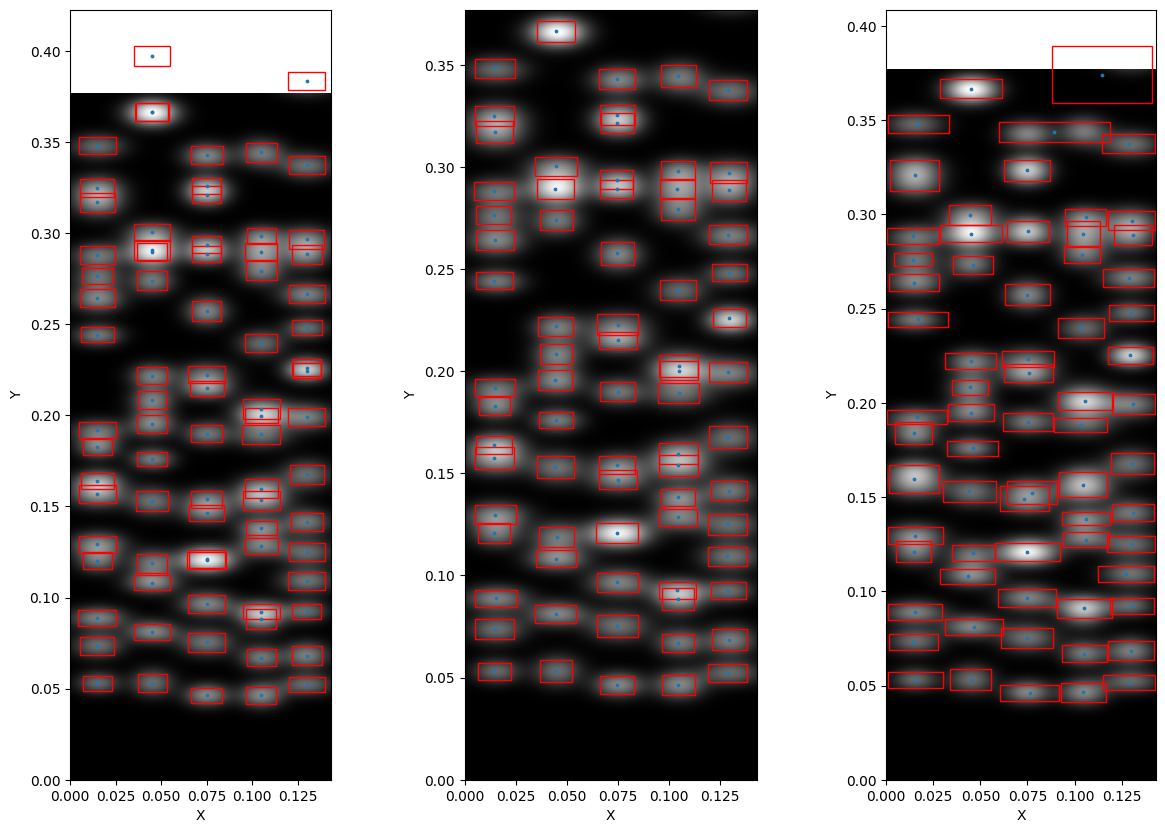

In [ ]:
# show plots
plt.show()
plt.ion()

# Annotations

## SPIDER
- Radius of each hole in the grid is 14 mm (hemsworth1996 - Original NB design);
- Design assumed the beams as two Gaussian parts, core with the 85% power with divergence of 5 mrad and the halo (15% power) with poor divergence of > 15 mrad (hemsworth1996 - Original NB design);
- Expected core beamlet divergence of as low as 2 - 3 mrad (hemsworth1996 - reference 11)

# Pipeline ppl_RNN
- Work of numbers from kaparty
- MASK R-CNN

# Pipeline ppl_CNN
  - Use a CNN to identify the Gaussians
    - Many questions, for example, how to analyse the whole image?
    - Yolo architecture of boxing/training might be a way
  - Check RetinaNet:
    - https://developers.arcgis.com/python/guide/how-retinanet-works/